# <font color='Blue'>Wandb Visualization of Machine Learning Performance and Deploying in Kubernates with KF Serving</font>



## 1 <font color='green'>Get the latest version of Weights and Biases Dependency & Kaggle Setup</font>

In [3]:
from tqdm import tqdm
for i in tqdm(range(2)):
     !pip install -q -r  requirements.txt --upgrade

  0%|          | 0/2 [00:00<?, ?it/s]

     |████████████████████████████████| 1.6MB 3.0MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 102kB 9.2MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 122kB 17.6MB/s 
     |████████████████████████████████| 163kB 16.2MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 


100%|██████████| 2/2 [00:15<00:00,  7.55s/it]


In [5]:
import wandb
import logging
import os
import numpy as np
import random as rn
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
from wandb.lightgbm import wandb_callback
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore");
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from sklearn.metrics import mean_squared_error
# Set seed for reproducability
seed = 1234
rn.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
# Surpress Pandas warnings
pd.set_option('chained_assignment', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.1 <font color='green'> Weights and Biases Dependency & Kaggle API Setup</font>

### 1.1.1 Weights & Biases [Link](https://docs.wandb.com/)

The steps to generate the API is mentioned in the Book.

In [ ]:
# Obfuscated WANDB API Key
WANDB_KEY = "ab0ab83e47545b9007e5f77eeb681ae530c0376c"

In [ ]:
!wandb login ab0ab83e47545b9007e5f77eeb681ae530c0376c

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


### 1.1.2 Kaggle [Link](http://kaggle.com)

The steps to generate the json is mentioned in the Book.

In [7]:
!mkdir ~/.kaggle 
!touch ~/.kaggle/kaggle.json
import json
api=json.load(open("/content/kaggle.json"))

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
import kaggle

In [ ]:
#kaggle datasets download -d numerai/encrypted-stock-market-data-from-numerai

In [9]:
logging.info(kaggle.api.authenticate())
kaggle.api.dataset_download_files('numerai/encrypted-stock-market-data-from-numerai', path='/content', unzip=True)
logging.info("Downloaded Data")

## 2 <font color='green'>Data Extraction and Loading</font>

In [10]:
data=pd.read_csv("/content/numerai_training_data.csv")
import numpy as np
data['target']=np.random.uniform(0,1,size=data.shape[0])
data.head(10)

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,0.137662,0.445825,0.471079,0.279196,0.275892,0.861967,0.305975,0.222414,0.893704,0.475781,0.071068,0.640546,0.024044,0.703299,0.128572,0.083492,0.639390,0.299443,0.055273,0.000308,0.784610,0.191519
1,0.651766,0.242053,0.720764,0.784000,0.685828,0.345841,0.038447,0.326108,0.760536,0.741738,0.741064,0.607355,0.544590,0.449178,0.547613,0.863165,0.832559,0.682060,0.009634,0.829331,0.969233,0.622109
2,0.810204,0.677403,0.538941,0.442458,0.662420,0.208793,0.592084,0.439066,0.442903,0.404538,0.368161,0.472579,0.796002,0.361473,0.395270,0.390462,0.086536,0.578854,0.603345,0.265151,0.052699,0.437728
3,0.672010,0.534088,0.336534,0.813820,0.331032,0.278800,0.443542,0.728365,0.573129,0.603860,0.543855,0.679266,0.190886,0.553522,0.403684,0.827155,0.102396,0.323720,0.656344,0.704652,0.152971,0.785359
4,0.763534,0.070120,0.353167,0.440987,0.426678,0.887997,0.747788,0.975318,0.338439,0.406945,0.552693,0.436036,0.440494,0.141096,0.613245,0.508625,0.315753,0.397510,0.111777,0.473443,0.259582,0.779976
5,0.175197,0.903275,0.831122,0.352198,0.861245,0.943256,0.380530,0.471236,0.145030,0.075545,0.297007,0.150487,0.865054,0.988360,0.659729,0.307391,0.725152,0.677277,0.996102,0.085978,0.665565,0.272593
6,0.293815,0.486859,0.406731,0.378480,0.655317,0.993008,0.479166,0.307666,0.456536,0.436276,0.247389,0.771730,0.705221,0.510426,0.475316,0.374219,0.735869,0.381512,0.397901,0.197141,0.449366,0.276464
7,0.931550,0.203539,0.500437,0.798114,0.274437,0.480022,0.934659,0.906963,0.604370,0.710110,0.808054,0.644627,0.008948,0.679636,0.704366,0.676740,0.385101,0.819954,0.405756,0.430342,0.347291,0.801872
8,0.191493,0.355400,0.043729,0.783918,0.055275,0.663969,0.523380,0.335758,0.012116,0.029072,0.304929,0.019346,0.041778,0.054765,0.287321,0.904292,0.696612,0.456116,0.558950,0.723156,0.217501,0.958139
9,0.191739,0.922918,1.000000,0.171776,0.888017,0.655597,0.339694,0.474380,0.202013,0.245507,0.679766,0.012689,0.769760,0.984328,0.733930,0.008020,0.561396,0.592602,0.969489,0.092085,0.433579,0.875933


In [11]:
train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

61644 train examples
15412 validation examples
19264 test examples


## 3 <font color='green'>Exploratory Data Analysis (EDA)</font>


# Plolty

In [15]:
def correlation_plot(data):
    correlation = data.corr()
    matrix_cols = correlation.columns.tolist()
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,x = matrix_cols,y = matrix_cols,xgap = 2,ygap = 2,
                       colorscale='Plasma',colorbar   = dict())
    layout = go.Layout(dict(title = 'Correlation Matrix for variables', autosize = False,
                        height  = 900,width   = 1000,margin  = dict(r = 0 ,l = 210, t = 25,b = 210),
        yaxis   = dict(tickfont = dict(size = 9)),xaxis   = dict(tickfont = dict(size = 9))))
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

In [17]:
correlation_plot(data)

# Seaborn

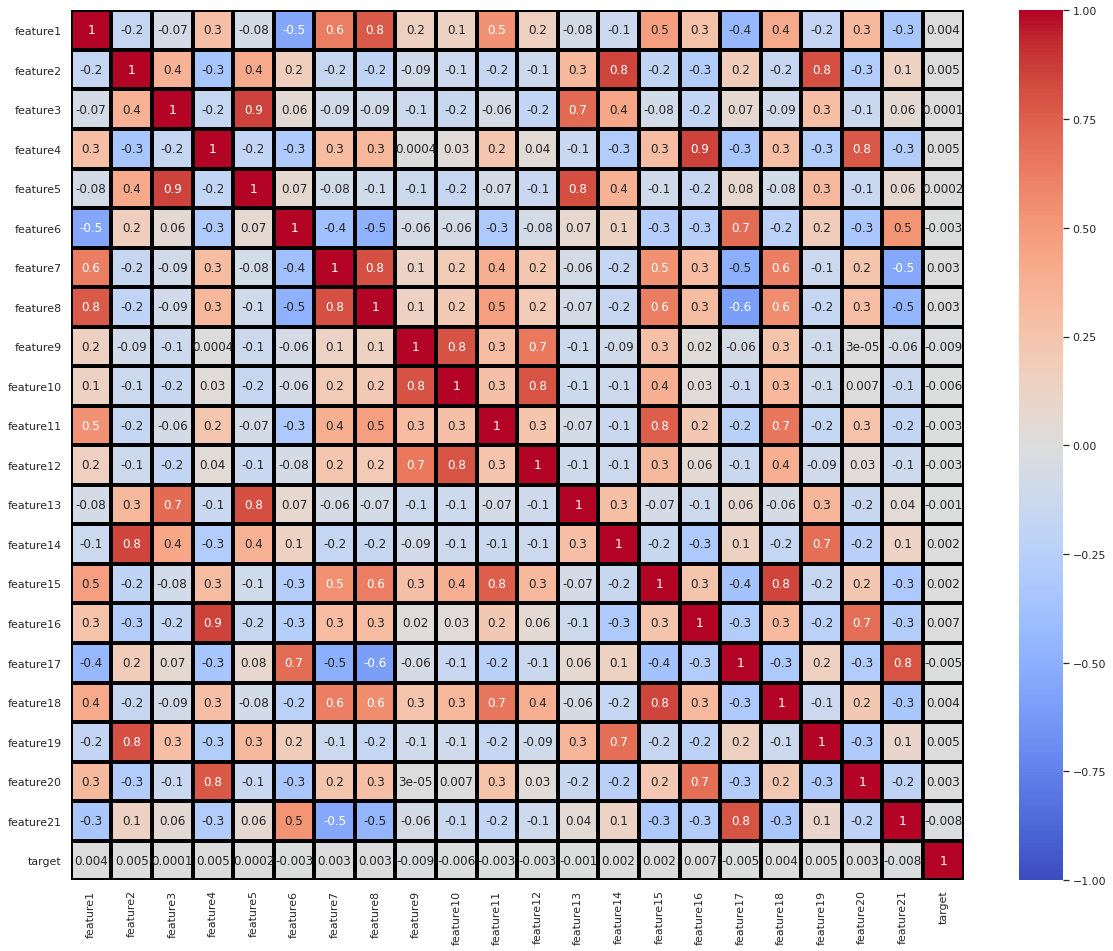

In [18]:
sns.set(rc={'figure.figsize':(20,16)})
sns.heatmap(data.corr(), annot = True,fmt='.1g',vmin=-1, vmax=1, center= 0,cmap= 'coolwarm', linewidths=3, linecolor='black')

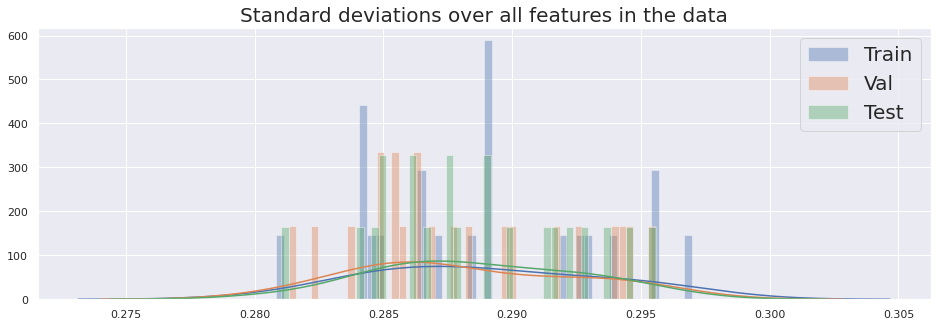

In [ ]:
feats = [f for f in train.columns if "feature" in f]
plt.figure(figsize=(16, 5))
sns.distplot(pd.DataFrame(train[feats].std()), bins=50)
sns.distplot(pd.DataFrame(val[feats].std()), bins=50)
sns.distplot(pd.DataFrame(test[feats].std()), bins=50)
plt.legend(["Train", "Val", "Test"], fontsize=20)
plt.title("Standard deviations over all features in the data", fontsize=20);

In [ ]:
print("Training data:")
display(train.head(2))
print("Test data:")
display(test.head(2))

Training data:


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
79509,0.765144,0.053363,0.160358,0.944992,0.088161,0.139893,0.792961,0.918887,0.782376,0.901637,0.736735,0.906824,0.440483,0.117200,0.803610,0.676672,0.135279,0.746022,0.110234,0.731515,0.321569,0.219252
65973,0.064776,0.420331,0.998819,0.612989,0.925742,0.669911,0.369894,0.057899,0.609403,0.674646,0.848267,0.285622,0.907038,0.460895,0.831721,0.160865,0.815272,0.922235,0.594581,0.176169,0.412193,0.492815


Test data:


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
90340,0.504585,0.621176,0.508424,0.824639,0.160589,0.736220,0.176231,0.246791,0.724531,0.655017,0.502018,0.791805,0.102991,0.696976,0.040094,0.974145,0.952395,0.042680,0.740137,0.829636,0.963613,0.113032
69842,0.093983,0.250148,0.499126,0.687236,0.110374,0.589843,0.088473,0.133699,0.665567,0.476928,0.155911,0.653973,0.382801,0.328786,0.158763,0.507942,0.909412,0.188714,0.387631,0.305675,0.838500,0.409395


In [ ]:
feature_list = list(train.columns)
feature_list.remove("target")

##  <font color='green'>4 Metrics Function</font>


In [ ]:
def evaluate(df: pd.DataFrame) -> tuple:
    """
    Evaluate and display relevant metrics for Numerai 
    
    :param df: A Pandas DataFrame containing the columns, "target" and a column for predictions
    :param pred_col: The column where the predictions are stored
    :return: A tuple of float containing the metrics
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """Calculates Spearman correlation"""
        return spearmanr(sub_df["target"], sub_df["prediction"])[0]
    
  
    mae = mean_absolute_error(df["target"], df["prediction"]).round(4)
    RMSE=mean_squared_error(df["target"], df["prediction"])** 0.5
    spearman=spearmanr(df["target"], df["prediction"])[0]

    # Display metrics
    print(f"Spearman Correlation: {spearman}")
    print(f"RMSE Score: {RMSE}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return spearman,RMSE, mae

##  <font color='green'>5 Training Model (using Weights and Biases) with LightGBM Framework</font>
To get a first good model for  we will train a [LightGBM](https://lightgbm.readthedocs.io/en/latest) model and use Weights and Biases to do a hyperparameter sweep. In this example it will be a grid search over some of the most important hyperparameters for LightGBM. First, we define the configuration of the sweep.


In [ ]:
# Configuration for hyperparameter sweep
sweep_config = {
   'method': 'grid',
   'metric': {
          'name': 'mse',
          'goal': 'minimize'   
        },
   'parameters': {
       "num_leaves": {'values': [30, 40, 50]}, 
       "max_depth": {'values': [4, 5, 6, 7]}, 
       "learning_rate": {'values': [0.1, 0.05, 0.01]},
       "bagging_freq": {'values': [7]}, 
       "bagging_fraction": {'values': [0.6, 0.7, 0.8]}, 
       "feature_fraction": {'values': [0.85, 0.75, 0.65]},
   }
}
sweep_id = wandb.sweep(sweep_config, project="simpletransformers")

Create sweep with ID: d3b06lm9
Sweep URL: https://app.wandb.ai/aniruddha/simpletransformers/sweeps/d3b06lm9


In [ ]:
dtrain = lgb.Dataset(train[feature_list], label=train["target"])
dvalid = lgb.Dataset(val[feature_list], label=val["target"])
watchlist = [dtrain, dvalid]

In [ ]:
def _train():
    # Configure and train model
    wandb.init(name="LightGBM_sweep")
    lgbm_config = {"num_leaves": wandb.config.num_leaves, "max_depth": wandb.config.max_depth, "learning_rate": wandb.config.learning_rate,
                   "bagging_freq": wandb.config.bagging_freq, "bagging_fraction": wandb.config.bagging_fraction, "feature_fraction": wandb.config.feature_fraction,
                   "metric": 'mse', "random_state": seed,
       }
    lgbm_model = lgb.train(lgbm_config, train_set=dtrain, num_boost_round=750, valid_sets=watchlist, 
                           callbacks=[wandb_callback()], verbose_eval=100, early_stopping_rounds=50)
    
    # Create predictions for evaluation
    val_preds = lgbm_model.predict(val[feature_list], num_iteration=lgbm_model.best_iteration)
    print(val_preds)
    print(type(val_preds))
    val.loc[:, "prediction"] = val_preds
    # W&B log metrics
    spearman,RMSE, mae = evaluate(val)
    wandb.log({"Spearman": spearman, "RMSE": RMSE, "Mean Absolute Error": mae})
    #lgb_path = '/content/'
    save_to = "/content/lgb_classifier.txt"
    lgbm_model.save_model(save_to)

In [ ]:

# Run hyperparameter sweep (grid search)
wandb.agent(sweep_id, function=_train)

INFO:wandb.wandb_agent:Running runs: []
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: u5n9ep55 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: u5n9ep55


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835953	valid_1's l2: 0.0827124
[0.5026042 0.5016406 0.5016406 ... 0.5016406 0.5026042 0.5016406]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004787618906806593
RMSE Score: 0.2875976805060863
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: u5n9ep55 



INFO:wandb.wandb_agent:Running runs: ['u5n9ep55']
INFO:wandb.wandb_agent:Cleaning up finished run: u5n9ep55
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: b9ml3fz3 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: b9ml3fz3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835953	valid_1's l2: 0.0827124
[0.5026042 0.5016406 0.5016406 ... 0.5016406 0.5026042 0.5016406]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004787618906806593
RMSE Score: 0.2875976805060863
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: b9ml3fz3 



INFO:wandb.wandb_agent:Running runs: ['b9ml3fz3']
INFO:wandb.wandb_agent:Cleaning up finished run: b9ml3fz3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: c3l8agty with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: c3l8agty


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835953	valid_1's l2: 0.0827124
[0.5026042 0.5016406 0.5016406 ... 0.5016406 0.5026042 0.5016406]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004787618906806593
RMSE Score: 0.2875976805060863
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: c3l8agty 



INFO:wandb.wandb_agent:Running runs: ['c3l8agty']
INFO:wandb.wandb_agent:Cleaning up finished run: c3l8agty
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: 8lsrqf8l with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: 8lsrqf8l


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0835608	valid_1's l2: 0.0826909
[0.50239012 0.50176457 0.50176457 ... 0.50176457 0.50239012 0.50071137]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012793585415381272
RMSE Score: 0.28756018871030553
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: 8lsrqf8l 



INFO:wandb.wandb_agent:Running runs: ['8lsrqf8l']
INFO:wandb.wandb_agent:Cleaning up finished run: 8lsrqf8l
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: laddrl75 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: laddrl75


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.08356	valid_1's l2: 0.0826919
[0.50239012 0.50176457 0.50176457 ... 0.50176457 0.50239012 0.50071137]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012784442757793441
RMSE Score: 0.2875620637039309
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: laddrl75 



INFO:wandb.wandb_agent:Running runs: ['laddrl75']
INFO:wandb.wandb_agent:Cleaning up finished run: laddrl75
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: 0zup6b3v with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: 0zup6b3v


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.08356	valid_1's l2: 0.0826919
[0.50239012 0.50176457 0.50176457 ... 0.50176457 0.50239012 0.50071137]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012784442757793441
RMSE Score: 0.2875620637039309
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: 0zup6b3v 



INFO:wandb.wandb_agent:Running runs: ['0zup6b3v']
INFO:wandb.wandb_agent:Cleaning up finished run: 0zup6b3v
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: h0ujf55k with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: h0ujf55k


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0835414	valid_1's l2: 0.0826909
[0.50238498 0.5017971  0.5017971  ... 0.5017971  0.50238498 0.50064298]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012793343893129515
RMSE Score: 0.28756019820255196
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: h0ujf55k 



INFO:wandb.wandb_agent:Running runs: ['h0ujf55k']
INFO:wandb.wandb_agent:Cleaning up finished run: h0ujf55k
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: fm0876u1 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: fm0876u1


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.083511	valid_1's l2: 0.0826955
[0.50285681 0.50154679 0.50154679 ... 0.50154679 0.50285681 0.50154679]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0077710884448193105
RMSE Score: 0.28756826394808815
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: fm0876u1 



INFO:wandb.wandb_agent:Running runs: ['fm0876u1']
INFO:wandb.wandb_agent:Cleaning up finished run: fm0876u1
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: jvbs3k2i with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: jvbs3k2i


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0835019	valid_1's l2: 0.0826968
[0.50285701 0.50154643 0.50154643 ... 0.50154643 0.50285701 0.50154643]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004474855776236894
RMSE Score: 0.28757050398944206
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: jvbs3k2i 



INFO:wandb.wandb_agent:Running runs: ['jvbs3k2i']
INFO:wandb.wandb_agent:Cleaning up finished run: jvbs3k2i
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: 83ct6nq3 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: 83ct6nq3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0833541	valid_1's l2: 0.0827023
[0.50075526 0.50178443 0.50075526 ... 0.50178443 0.50505213 0.50326987]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005146330525422306
RMSE Score: 0.2875801442313868
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: 83ct6nq3 



INFO:wandb.wandb_agent:Running runs: ['83ct6nq3']
INFO:wandb.wandb_agent:Cleaning up finished run: 83ct6nq3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: qkjtum76 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: qkjtum76


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0835044	valid_1's l2: 0.0826949
[0.50278762 0.50135729 0.50276479 ... 0.50135729 0.50278762 0.50135729]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011543765425980646
RMSE Score: 0.28756729413067383
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: qkjtum76 



INFO:wandb.wandb_agent:Running runs: ['qkjtum76']
INFO:wandb.wandb_agent:Cleaning up finished run: qkjtum76
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: 8485n582 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: 8485n582


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.083471	valid_1's l2: 0.0826793
[0.50280051 0.50153086 0.5029411  ... 0.50153086 0.50280051 0.50153086]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01807432584784825
RMSE Score: 0.2875401379990676
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: 8485n582 



INFO:wandb.wandb_agent:Running runs: ['8485n582']
INFO:wandb.wandb_agent:Cleaning up finished run: 8485n582
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: lmbrubks with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: lmbrubks


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0835592	valid_1's l2: 0.0827035
[0.50182817 0.5017267  0.50230128 ... 0.5017267  0.5025785  0.50216269]
<class 'numpy.ndarray'>
Spearman Correlation: 0.013455380189114633
RMSE Score: 0.2875821870584319
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: lmbrubks 



INFO:wandb.wandb_agent:Running runs: ['lmbrubks']
INFO:wandb.wandb_agent:Cleaning up finished run: lmbrubks
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: 5odlxv7s with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: 5odlxv7s


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0835592	valid_1's l2: 0.0827035
[0.50182817 0.5017267  0.50230128 ... 0.5017267  0.5025785  0.50216269]
<class 'numpy.ndarray'>
Spearman Correlation: 0.013455380189114633
RMSE Score: 0.2875821870584319
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 5odlxv7s 



INFO:wandb.wandb_agent:Running runs: ['5odlxv7s']
INFO:wandb.wandb_agent:Cleaning up finished run: 5odlxv7s
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: zir602sx with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: zir602sx


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0835592	valid_1's l2: 0.0827035
[0.50182817 0.5017267  0.50230128 ... 0.5017267  0.5025785  0.50216269]
<class 'numpy.ndarray'>
Spearman Correlation: 0.013455380189114633
RMSE Score: 0.2875821870584319
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: zir602sx 



INFO:wandb.wandb_agent:Running runs: ['zir602sx']
INFO:wandb.wandb_agent:Cleaning up finished run: zir602sx
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: s2quwttp with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: s2quwttp


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835903	valid_1's l2: 0.0827005
[0.50220079 0.50170705 0.50170705 ... 0.50170705 0.50220079 0.50170705]
<class 'numpy.ndarray'>
Spearman Correlation: 0.014660403594761654
RMSE Score: 0.28757696039498937
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: s2quwttp 



INFO:wandb.wandb_agent:Running runs: ['s2quwttp']
INFO:wandb.wandb_agent:Cleaning up finished run: s2quwttp
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 1ulvo0j3 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 1ulvo0j3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835893	valid_1's l2: 0.0827004
[0.50220079 0.50170705 0.50170705 ... 0.50170705 0.50220079 0.50170705]
<class 'numpy.ndarray'>
Spearman Correlation: 0.015196682048050886
RMSE Score: 0.28757669113104256
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 1ulvo0j3 



INFO:wandb.wandb_agent:Running runs: ['1ulvo0j3']
INFO:wandb.wandb_agent:Cleaning up finished run: 1ulvo0j3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: u866b9bt with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: u866b9bt


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835893	valid_1's l2: 0.0827004
[0.50220079 0.50170705 0.50170705 ... 0.50170705 0.50220079 0.50170705]
<class 'numpy.ndarray'>
Spearman Correlation: 0.015196682048050886
RMSE Score: 0.28757669113104256
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: u866b9bt 



INFO:wandb.wandb_agent:Running runs: ['u866b9bt']
INFO:wandb.wandb_agent:Cleaning up finished run: u866b9bt
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: megywvj8 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: megywvj8


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.083575	valid_1's l2: 0.0826989
[0.50216236 0.50170806 0.50170806 ... 0.50170806 0.50216236 0.50170806]
<class 'numpy.ndarray'>
Spearman Correlation: 0.010208320494549802
RMSE Score: 0.2875742451184618
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: megywvj8 



INFO:wandb.wandb_agent:Running runs: ['megywvj8']
INFO:wandb.wandb_agent:Cleaning up finished run: megywvj8
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: hrnpcz5j with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: hrnpcz5j


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	training's l2: 0.0835162	valid_1's l2: 0.0826859
[0.50202474 0.50160842 0.50160842 ... 0.50160842 0.50202474 0.50387792]
<class 'numpy.ndarray'>
Spearman Correlation: 0.015356523432501303
RMSE Score: 0.2875516091048728
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: hrnpcz5j 



INFO:wandb.wandb_agent:Running runs: ['hrnpcz5j']
INFO:wandb.wandb_agent:Cleaning up finished run: hrnpcz5j
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: vkhpldic with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: vkhpldic


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	training's l2: 0.0835017	valid_1's l2: 0.0826877
[0.50202505 0.50160847 0.50160847 ... 0.50160847 0.50202505 0.50387537]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01340557653688667
RMSE Score: 0.2875546264342151
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: vkhpldic 



INFO:wandb.wandb_agent:Running runs: ['vkhpldic']
INFO:wandb.wandb_agent:Cleaning up finished run: vkhpldic
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: 7wcp8k7i with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: 7wcp8k7i


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[9]	training's l2: 0.08337	valid_1's l2: 0.0827005
[0.50166171 0.5016799  0.50369364 ... 0.5016799  0.50401296 0.50232214]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0048146072273122405
RMSE Score: 0.28757692036278826
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: 7wcp8k7i 



INFO:wandb.wandb_agent:Running runs: ['7wcp8k7i']
INFO:wandb.wandb_agent:Cleaning up finished run: 7wcp8k7i
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: 9takf95y with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: 9takf95y


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	training's l2: 0.0834985	valid_1's l2: 0.0826852
[0.50197418 0.50170675 0.50170675 ... 0.50170675 0.50197418 0.50170675]
<class 'numpy.ndarray'>
Spearman Correlation: 0.015383720331609152
RMSE Score: 0.2875504232562831
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: 9takf95y 



INFO:wandb.wandb_agent:Running runs: ['9takf95y']
INFO:wandb.wandb_agent:Cleaning up finished run: 9takf95y
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: oa9bag3s with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: oa9bag3s


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0832424	valid_1's l2: 0.0826823
[0.50193165 0.50160294 0.50078296 ... 0.50160294 0.50457711 0.50718422]
<class 'numpy.ndarray'>
Spearman Correlation: 0.021395197956684618
RMSE Score: 0.2875453037474335
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: oa9bag3s 



INFO:wandb.wandb_agent:Running runs: ['oa9bag3s']
INFO:wandb.wandb_agent:Cleaning up finished run: oa9bag3s
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: za8kf4k9 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: za8kf4k9


Training until validation scores don't improve for 50 rounds.
[100]	training's l2: 0.0833971	valid_1's l2: 0.0826964
Early stopping, best iteration is:
[119]	training's l2: 0.0833518	valid_1's l2: 0.0826946
[0.50282008 0.50208386 0.49867745 ... 0.50278369 0.50206781 0.50168788]
<class 'numpy.ndarray'>
Spearman Correlation: 0.014160375886742307
RMSE Score: 0.2875666385326258
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: za8kf4k9 



INFO:wandb.wandb_agent:Running runs: ['za8kf4k9']
INFO:wandb.wandb_agent:Cleaning up finished run: za8kf4k9
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: ugv6t4ps with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: ugv6t4ps


Training until validation scores don't improve for 50 rounds.
[100]	training's l2: 0.0833971	valid_1's l2: 0.0826964
Early stopping, best iteration is:
[119]	training's l2: 0.0833518	valid_1's l2: 0.0826946
[0.50282008 0.50208386 0.49867745 ... 0.50278369 0.50206781 0.50168788]
<class 'numpy.ndarray'>
Spearman Correlation: 0.014160375886742307
RMSE Score: 0.2875666385326258
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: ugv6t4ps 



INFO:wandb.wandb_agent:Running runs: ['ugv6t4ps']
INFO:wandb.wandb_agent:Cleaning up finished run: ugv6t4ps
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: aj7htlfs with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: aj7htlfs


Training until validation scores don't improve for 50 rounds.
[100]	training's l2: 0.0833971	valid_1's l2: 0.0826964
Early stopping, best iteration is:
[119]	training's l2: 0.0833518	valid_1's l2: 0.0826946
[0.50282008 0.50208386 0.49867745 ... 0.50278369 0.50206781 0.50168788]
<class 'numpy.ndarray'>
Spearman Correlation: 0.014160375886742307
RMSE Score: 0.2875666385326258
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: aj7htlfs 



INFO:wandb.wandb_agent:Running runs: ['aj7htlfs']
INFO:wandb.wandb_agent:Cleaning up finished run: aj7htlfs
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: hmh7f7df with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: hmh7f7df


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0836234	valid_1's l2: 0.0827048
[0.50187162 0.50177298 0.50177298 ... 0.50177298 0.50187162 0.50177298]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01671028317100269
RMSE Score: 0.28758446240417646
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: hmh7f7df 



INFO:wandb.wandb_agent:Running runs: ['hmh7f7df']
INFO:wandb.wandb_agent:Cleaning up finished run: hmh7f7df
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 97tziard with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 97tziard


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0836232	valid_1's l2: 0.0827048
[0.50187162 0.50177299 0.50177299 ... 0.50177299 0.50187162 0.50177299]
<class 'numpy.ndarray'>
Spearman Correlation: 0.016823361937787464
RMSE Score: 0.2875844058255189
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 97tziard 



INFO:wandb.wandb_agent:Running runs: ['97tziard']
INFO:wandb.wandb_agent:Cleaning up finished run: 97tziard
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: gbp9jdfi with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: gbp9jdfi


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0836232	valid_1's l2: 0.0827048
[0.50187162 0.50177299 0.50177299 ... 0.50177299 0.50187162 0.50177299]
<class 'numpy.ndarray'>
Spearman Correlation: 0.016823361937787464
RMSE Score: 0.2875844058255189
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: gbp9jdfi 



INFO:wandb.wandb_agent:Running runs: ['gbp9jdfi']
INFO:wandb.wandb_agent:Cleaning up finished run: gbp9jdfi
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: wk7clpuh with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: wk7clpuh


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0836102	valid_1's l2: 0.0827037
[0.501842 0.501751 0.501751 ... 0.501751 0.501842 0.501922]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0036813929904469323
RMSE Score: 0.2875825057274651
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: wk7clpuh 



INFO:wandb.wandb_agent:Running runs: ['wk7clpuh']
INFO:wandb.wandb_agent:Cleaning up finished run: wk7clpuh
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: 0woatn1y with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: 0woatn1y


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0835965	valid_1's l2: 0.0827053
[0.50184952 0.50176624 0.50176624 ... 0.50176624 0.50184952 0.5019374 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0016634752368645488
RMSE Score: 0.2875852830558297
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 0woatn1y 



INFO:wandb.wandb_agent:Running runs: ['0woatn1y']
INFO:wandb.wandb_agent:Cleaning up finished run: 0woatn1y
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: d052ny7i with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: d052ny7i


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0835915	valid_1's l2: 0.0827056
[0.50185213 0.50176885 0.50176885 ... 0.50176885 0.50185213 0.50193992]
<class 'numpy.ndarray'>
Spearman Correlation: -0.002015519955847766
RMSE Score: 0.2875857731011077
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: d052ny7i 



INFO:wandb.wandb_agent:Running runs: ['d052ny7i']
INFO:wandb.wandb_agent:Cleaning up finished run: d052ny7i
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: agtweb9b with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: agtweb9b


Training until validation scores don't improve for 50 rounds.
[100]	training's l2: 0.0830153	valid_1's l2: 0.0827079
Early stopping, best iteration is:
[59]	training's l2: 0.0832813	valid_1's l2: 0.0827001
[0.50235383 0.50204882 0.49869804 ... 0.50425391 0.50058018 0.50398902]
<class 'numpy.ndarray'>
Spearman Correlation: 0.017917232537046766
RMSE Score: 0.28757617944500097
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: agtweb9b 



INFO:wandb.wandb_agent:Running runs: ['agtweb9b']
INFO:wandb.wandb_agent:Cleaning up finished run: agtweb9b
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: c3mc8re5 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: c3mc8re5


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[11]	training's l2: 0.0835756	valid_1's l2: 0.0827008
[0.5019568  0.50174482 0.5017033  ... 0.50174482 0.50193112 0.50209933]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01126685031008396
RMSE Score: 0.28757741839768886
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: c3mc8re5 



INFO:wandb.wandb_agent:Running runs: ['c3mc8re5']
INFO:wandb.wandb_agent:Cleaning up finished run: c3mc8re5
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: du4zzrnt with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: du4zzrnt


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0835445	valid_1's l2: 0.0827008
[0.5019271  0.50172118 0.50261159 ... 0.50172118 0.50190081 0.50207568]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01204415985883972
RMSE Score: 0.2875774822533355
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: du4zzrnt 



INFO:wandb.wandb_agent:Running runs: ['du4zzrnt']
INFO:wandb.wandb_agent:Cleaning up finished run: du4zzrnt
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: 4r0497hg with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: 4r0497hg


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0836159	valid_1's l2: 0.0826997
[0.50251931 0.50168221 0.50168221 ... 0.50168221 0.50251931 0.50168221]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0063740831177790825
RMSE Score: 0.2875756201056783
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 4r0497hg 



INFO:wandb.wandb_agent:Running runs: ['4r0497hg']
INFO:wandb.wandb_agent:Cleaning up finished run: 4r0497hg
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: ehwuv1it with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: ehwuv1it


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0836159	valid_1's l2: 0.0826997
[0.50251931 0.50168221 0.50168221 ... 0.50168221 0.50251931 0.50168221]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0063740831177790825
RMSE Score: 0.2875756201056783
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ehwuv1it 



INFO:wandb.wandb_agent:Running runs: ['ehwuv1it']
INFO:wandb.wandb_agent:Cleaning up finished run: ehwuv1it
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: 30ik98cq with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: 30ik98cq


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0836159	valid_1's l2: 0.0826997
[0.50251931 0.50168221 0.50168221 ... 0.50168221 0.50251931 0.50168221]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0063740831177790825
RMSE Score: 0.2875756201056783
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 30ik98cq 



INFO:wandb.wandb_agent:Running runs: ['30ik98cq']
INFO:wandb.wandb_agent:Cleaning up finished run: 30ik98cq
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: nly69nj9 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: nly69nj9


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836178	valid_1's l2: 0.0827037
[0.50166691 0.50166691 0.50166691 ... 0.50166691 0.50166691 0.50166691]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00809203510182303
RMSE Score: 0.28758255132595445
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: nly69nj9 



INFO:wandb.wandb_agent:Running runs: ['nly69nj9']
INFO:wandb.wandb_agent:Cleaning up finished run: nly69nj9
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 3m3an6yk with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 3m3an6yk


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836178	valid_1's l2: 0.0827037
[0.50166691 0.50166691 0.50166691 ... 0.50166691 0.50166691 0.50166691]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00809203510182303
RMSE Score: 0.28758255132595445
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 3m3an6yk 



INFO:wandb.wandb_agent:Running runs: ['3m3an6yk']
INFO:wandb.wandb_agent:Cleaning up finished run: 3m3an6yk
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: 8v5cpqsh with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: 8v5cpqsh


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836178	valid_1's l2: 0.0827037
[0.50166691 0.50166691 0.50166691 ... 0.50166691 0.50166691 0.50166691]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00809203510182303
RMSE Score: 0.28758255132595445
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 8v5cpqsh 



INFO:wandb.wandb_agent:Running runs: ['8v5cpqsh']
INFO:wandb.wandb_agent:Cleaning up finished run: 8v5cpqsh
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: 46xump0y with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: 46xump0y


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836063	valid_1's l2: 0.082702
[0.50172729 0.50172729 0.50172729 ... 0.50172729 0.50172729 0.50172729]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0015849133016800961
RMSE Score: 0.2875795589404831
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 46xump0y 



INFO:wandb.wandb_agent:Running runs: ['46xump0y']
INFO:wandb.wandb_agent:Cleaning up finished run: 46xump0y
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: tz3doxvg with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: tz3doxvg


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835904	valid_1's l2: 0.0826957
[0.50172729 0.50172729 0.50172729 ... 0.50172729 0.50172729 0.50172729]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00631902399765374
RMSE Score: 0.2875685650558899
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: tz3doxvg 



INFO:wandb.wandb_agent:Running runs: ['tz3doxvg']
INFO:wandb.wandb_agent:Cleaning up finished run: tz3doxvg
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: 0patm7rj with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: 0patm7rj


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.083585	valid_1's l2: 0.0826978
[0.50172729 0.50172729 0.50172729 ... 0.50172729 0.50172729 0.50172729]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007058598821055967
RMSE Score: 0.28757229071878904
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 0patm7rj 



INFO:wandb.wandb_agent:Running runs: ['0patm7rj']
INFO:wandb.wandb_agent:Cleaning up finished run: 0patm7rj
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: v1agc2s7 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: v1agc2s7


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0831762	valid_1's l2: 0.0827014
[0.50135529 0.50211822 0.50188546 ... 0.50211822 0.50491646 0.50905299]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004182330644847119
RMSE Score: 0.2875784508981509
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: v1agc2s7 



INFO:wandb.wandb_agent:Running runs: ['v1agc2s7']
INFO:wandb.wandb_agent:Cleaning up finished run: v1agc2s7
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: dfbbt712 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: dfbbt712


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835841	valid_1's l2: 0.0827002
[0.50156556 0.50156556 0.50156556 ... 0.50156556 0.50156556 0.50331323]
<class 'numpy.ndarray'>
Spearman Correlation: -0.000731720930558352
RMSE Score: 0.28757634127141485
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: dfbbt712 



INFO:wandb.wandb_agent:Running runs: ['dfbbt712']
INFO:wandb.wandb_agent:Cleaning up finished run: dfbbt712
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: zyuza750 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: zyuza750


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835654	valid_1's l2: 0.0826923
[0.50156556 0.50156556 0.50156556 ... 0.50156556 0.50156556 0.50331323]
<class 'numpy.ndarray'>
Spearman Correlation: 0.002426218118090049
RMSE Score: 0.2875626340182334
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: zyuza750 



INFO:wandb.wandb_agent:Running runs: ['zyuza750']
INFO:wandb.wandb_agent:Cleaning up finished run: zyuza750
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: 0cgmlobe with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: 0cgmlobe


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0835646	valid_1's l2: 0.082698
[0.50191989 0.50144356 0.50239009 ... 0.50144356 0.50191989 0.50225634]
<class 'numpy.ndarray'>
Spearman Correlation: 0.014948086727003037
RMSE Score: 0.28757268231240757
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 0cgmlobe 



INFO:wandb.wandb_agent:Running runs: ['0cgmlobe']
INFO:wandb.wandb_agent:Cleaning up finished run: 0cgmlobe
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: eh1m0hb3 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: eh1m0hb3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0835646	valid_1's l2: 0.082698
[0.50191989 0.50144356 0.50239009 ... 0.50144356 0.50191989 0.50225634]
<class 'numpy.ndarray'>
Spearman Correlation: 0.014948086727003037
RMSE Score: 0.28757268231240757
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: eh1m0hb3 



INFO:wandb.wandb_agent:Running runs: ['eh1m0hb3']
INFO:wandb.wandb_agent:Cleaning up finished run: eh1m0hb3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: wnwp6p8f with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: wnwp6p8f


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0835646	valid_1's l2: 0.082698
[0.50191989 0.50144356 0.50239009 ... 0.50144356 0.50191989 0.50225634]
<class 'numpy.ndarray'>
Spearman Correlation: 0.014948086727003037
RMSE Score: 0.28757268231240757
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: wnwp6p8f 



INFO:wandb.wandb_agent:Running runs: ['wnwp6p8f']
INFO:wandb.wandb_agent:Cleaning up finished run: wnwp6p8f
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: 5zlwn5j6 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: 5zlwn5j6


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	training's l2: 0.0835715	valid_1's l2: 0.0827028
[0.50211748 0.5016977  0.5016977  ... 0.5016977  0.50211748 0.5016977 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011937337070672339
RMSE Score: 0.28758088322660397
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 5zlwn5j6 



INFO:wandb.wandb_agent:Running runs: ['5zlwn5j6']
INFO:wandb.wandb_agent:Cleaning up finished run: 5zlwn5j6
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 9b138ehd with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 9b138ehd


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	training's l2: 0.0835715	valid_1's l2: 0.0827028
[0.50211748 0.5016977  0.5016977  ... 0.5016977  0.50211748 0.5016977 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011937337070672339
RMSE Score: 0.28758088322660397
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 9b138ehd 



INFO:wandb.wandb_agent:Running runs: ['9b138ehd']
INFO:wandb.wandb_agent:Cleaning up finished run: 9b138ehd
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: f43i9wk4 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: f43i9wk4


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	training's l2: 0.0835715	valid_1's l2: 0.0827028
[0.50211748 0.5016977  0.5016977  ... 0.5016977  0.50211748 0.5016977 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011937337070672339
RMSE Score: 0.28758088322660397
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: f43i9wk4 



INFO:wandb.wandb_agent:Running runs: ['f43i9wk4']
INFO:wandb.wandb_agent:Cleaning up finished run: f43i9wk4
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: 1qhvppml with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: 1qhvppml


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	training's l2: 0.0835467	valid_1's l2: 0.0827021
[0.50177287 0.50156834 0.50156834 ... 0.50156834 0.50177287 0.50156834]
<class 'numpy.ndarray'>
Spearman Correlation: 0.013247796570376039
RMSE Score: 0.28757975664570196
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 1qhvppml 



INFO:wandb.wandb_agent:Running runs: ['1qhvppml']
INFO:wandb.wandb_agent:Cleaning up finished run: 1qhvppml
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: 5wmf3hq3 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: 5wmf3hq3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835511	valid_1's l2: 0.0827008
[0.50188928 0.50168436 0.50168436 ... 0.50168436 0.50188928 0.50168436]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01067989174237507
RMSE Score: 0.28757748138490563
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 5wmf3hq3 



INFO:wandb.wandb_agent:Running runs: ['5wmf3hq3']
INFO:wandb.wandb_agent:Cleaning up finished run: 5wmf3hq3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: 5mrzcb1j with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: 5mrzcb1j


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0835858	valid_1's l2: 0.082702
[0.5019806  0.50177536 0.50177536 ... 0.50177536 0.5019806  0.50177536]
<class 'numpy.ndarray'>
Spearman Correlation: 0.013301094910758907
RMSE Score: 0.2875794981132305
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 5mrzcb1j 



INFO:wandb.wandb_agent:Running runs: ['5mrzcb1j']
INFO:wandb.wandb_agent:Cleaning up finished run: 5mrzcb1j
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: lwg8f0u8 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: lwg8f0u8


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0835169	valid_1's l2: 0.0826916
[0.50230387 0.50171557 0.50171557 ... 0.50171557 0.50230387 0.50171557]
<class 'numpy.ndarray'>
Spearman Correlation: 0.015576597165183644
RMSE Score: 0.28756151094434834
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: lwg8f0u8 



INFO:wandb.wandb_agent:Running runs: ['lwg8f0u8']
INFO:wandb.wandb_agent:Cleaning up finished run: lwg8f0u8
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: 0k5akumn with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: 0k5akumn


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	training's l2: 0.0830288	valid_1's l2: 0.0826854
[0.500816   0.50109107 0.50065063 ... 0.50129481 0.50262608 0.50163166]
<class 'numpy.ndarray'>
Spearman Correlation: 0.014757003540972164
RMSE Score: 0.28755068785650995
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: 0k5akumn 



INFO:wandb.wandb_agent:Running runs: ['0k5akumn']
INFO:wandb.wandb_agent:Cleaning up finished run: 0k5akumn
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: ajhow3k4 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: ajhow3k4


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	training's l2: 0.0829085	valid_1's l2: 0.0826866
[0.51167346 0.50100578 0.49535903 ... 0.50230874 0.50285905 0.5006201 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.013002501254978543
RMSE Score: 0.2875527557177237
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: ajhow3k4 



INFO:wandb.wandb_agent:Running runs: ['ajhow3k4']
INFO:wandb.wandb_agent:Cleaning up finished run: ajhow3k4
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: jdftofbo with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: jdftofbo


Training until validation scores don't improve for 50 rounds.
[100]	training's l2: 0.0834028	valid_1's l2: 0.0827095
Early stopping, best iteration is:
[126]	training's l2: 0.0833374	valid_1's l2: 0.0827064
[0.50267265 0.50218803 0.49870282 ... 0.49938385 0.50131954 0.50332085]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011797759236816124
RMSE Score: 0.287587152060896
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: jdftofbo 



INFO:wandb.wandb_agent:Running runs: ['jdftofbo']
INFO:wandb.wandb_agent:Cleaning up finished run: jdftofbo
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: 4mid6xkr with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: 4mid6xkr


Training until validation scores don't improve for 50 rounds.
[100]	training's l2: 0.0834028	valid_1's l2: 0.0827095


INFO:wandb.wandb_agent:Running runs: ['4mid6xkr']


Early stopping, best iteration is:
[126]	training's l2: 0.0833374	valid_1's l2: 0.0827064
[0.50267265 0.50218803 0.49870282 ... 0.49938385 0.50131954 0.50332085]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011797759236816124
RMSE Score: 0.287587152060896
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 4mid6xkr 



INFO:wandb.wandb_agent:Cleaning up finished run: 4mid6xkr
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: oag9xm57 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: oag9xm57


Training until validation scores don't improve for 50 rounds.
[100]	training's l2: 0.0834028	valid_1's l2: 0.0827095


INFO:wandb.wandb_agent:Running runs: ['oag9xm57']


Early stopping, best iteration is:
[126]	training's l2: 0.0833374	valid_1's l2: 0.0827064
[0.50267265 0.50218803 0.49870282 ... 0.49938385 0.50131954 0.50332085]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011797759236816124
RMSE Score: 0.287587152060896
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: oag9xm57 



INFO:wandb.wandb_agent:Cleaning up finished run: oag9xm57
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: mky51a3q with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: mky51a3q


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0836256	valid_1's l2: 0.0827075
[0.50184378 0.50175999 0.50212518 ... 0.50175999 0.50184378 0.50167931]
<class 'numpy.ndarray'>
Spearman Correlation: 0.006675646073923356
RMSE Score: 0.2875891664962315
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: mky51a3q 



INFO:wandb.wandb_agent:Running runs: ['mky51a3q']
INFO:wandb.wandb_agent:Cleaning up finished run: mky51a3q
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 5w3ilze2 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 5w3ilze2


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0836256	valid_1's l2: 0.0827075
[0.50184378 0.50175999 0.50212518 ... 0.50175999 0.50184378 0.50167931]
<class 'numpy.ndarray'>
Spearman Correlation: 0.006675646073923356
RMSE Score: 0.2875891664962315
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 5w3ilze2 



INFO:wandb.wandb_agent:Running runs: ['5w3ilze2']
INFO:wandb.wandb_agent:Cleaning up finished run: 5w3ilze2
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: i5zcb4mj with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: i5zcb4mj


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0836256	valid_1's l2: 0.0827075
[0.50184378 0.50175999 0.50212518 ... 0.50175999 0.50184378 0.50167931]
<class 'numpy.ndarray'>
Spearman Correlation: 0.006675646073923356
RMSE Score: 0.2875891664962315
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: i5zcb4mj 



INFO:wandb.wandb_agent:Running runs: ['i5zcb4mj']
INFO:wandb.wandb_agent:Cleaning up finished run: i5zcb4mj
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: 2k95tp7k with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: 2k95tp7k


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	training's l2: 0.0835742	valid_1's l2: 0.0827046
[0.50193645 0.50169667 0.50210119 ... 0.50185045 0.50193645 0.50163614]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012501066620427633
RMSE Score: 0.28758401262307104
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 2k95tp7k 



INFO:wandb.wandb_agent:Running runs: ['2k95tp7k']
INFO:wandb.wandb_agent:Cleaning up finished run: 2k95tp7k
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: avbb0t0r with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: avbb0t0r


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	training's l2: 0.0835523	valid_1's l2: 0.0827054
[0.50191342 0.50169826 0.50249929 ... 0.50173287 0.50191342 0.50162486]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011964944952367227
RMSE Score: 0.28758542372520207
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: avbb0t0r 



INFO:wandb.wandb_agent:Running runs: ['avbb0t0r']
INFO:wandb.wandb_agent:Cleaning up finished run: avbb0t0r
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: ld7b7z0m with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: ld7b7z0m


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	training's l2: 0.0835449	valid_1's l2: 0.082705
[0.50191878 0.50170354 0.50225116 ... 0.50173822 0.50191878 0.50174193]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012644866320906804
RMSE Score: 0.28758471379703054
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ld7b7z0m 



INFO:wandb.wandb_agent:Running runs: ['ld7b7z0m']
INFO:wandb.wandb_agent:Cleaning up finished run: ld7b7z0m
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: 7krn6k4f with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: 7krn6k4f


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	training's l2: 0.0835777	valid_1's l2: 0.0827046
[0.50197587 0.50167673 0.5029332  ... 0.50184555 0.50197587 0.50180564]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008524815071541387
RMSE Score: 0.28758410008570223
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 7krn6k4f 



INFO:wandb.wandb_agent:Running runs: ['7krn6k4f']
INFO:wandb.wandb_agent:Cleaning up finished run: 7krn6k4f
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: lhwntkh5 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: lhwntkh5


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	training's l2: 0.0835475	valid_1's l2: 0.0827051
[0.50224234 0.50168707 0.50314697 ... 0.50203141 0.50212778 0.50193268]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008111776551007746
RMSE Score: 0.28758497518827647
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: lhwntkh5 



INFO:wandb.wandb_agent:Running runs: ['lhwntkh5']
INFO:wandb.wandb_agent:Cleaning up finished run: lhwntkh5
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: vk4ui75g with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: vk4ui75g


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	training's l2: 0.0835209	valid_1's l2: 0.0827032
[0.50216312 0.50169589 0.50059396 ... 0.50203304 0.50212852 0.50193443]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00872381695706543
RMSE Score: 0.28758165071970193
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: vk4ui75g 



INFO:wandb.wandb_agent:Running runs: ['vk4ui75g']
INFO:wandb.wandb_agent:Cleaning up finished run: vk4ui75g
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: oflgjjxz with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: oflgjjxz


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835942	valid_1's l2: 0.0827
[0.50178923 0.50172017 0.50204574 ... 0.50172017 0.50369793 0.5031323 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005919953233916654
RMSE Score: 0.28757600079469314
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: oflgjjxz 



INFO:wandb.wandb_agent:Running runs: ['oflgjjxz']
INFO:wandb.wandb_agent:Cleaning up finished run: oflgjjxz
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: 9lz5aini with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: 9lz5aini


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835942	valid_1's l2: 0.0827
[0.50178923 0.50172017 0.50204574 ... 0.50172017 0.50369793 0.5031323 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005919953233916654
RMSE Score: 0.28757600079469314
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 9lz5aini 



INFO:wandb.wandb_agent:Running runs: ['9lz5aini']
INFO:wandb.wandb_agent:Cleaning up finished run: 9lz5aini
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: ezj6nfwc with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: ezj6nfwc


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835942	valid_1's l2: 0.0827
[0.50178923 0.50172017 0.50204574 ... 0.50172017 0.50369793 0.5031323 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005919953233916654
RMSE Score: 0.28757600079469314
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ezj6nfwc 



INFO:wandb.wandb_agent:Running runs: ['ezj6nfwc']
INFO:wandb.wandb_agent:Cleaning up finished run: ezj6nfwc
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: olfeh0g6 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: olfeh0g6


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836221	valid_1's l2: 0.0827097
[0.50176208 0.50176208 0.50176208 ... 0.50176208 0.50176208 0.50176208]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007559672376389581
RMSE Score: 0.2875929992917508
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: olfeh0g6 



INFO:wandb.wandb_agent:Running runs: ['olfeh0g6']
INFO:wandb.wandb_agent:Cleaning up finished run: olfeh0g6
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: abrwv25c with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: abrwv25c


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836221	valid_1's l2: 0.0827097
[0.50176208 0.50176208 0.50176208 ... 0.50176208 0.50176208 0.50176208]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007559672376389581
RMSE Score: 0.2875929992917508
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: abrwv25c 



INFO:wandb.wandb_agent:Running runs: ['abrwv25c']
INFO:wandb.wandb_agent:Cleaning up finished run: abrwv25c
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: wq7f17ub with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: wq7f17ub


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836221	valid_1's l2: 0.0827097
[0.50176208 0.50176208 0.50176208 ... 0.50176208 0.50176208 0.50176208]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007559672376389581
RMSE Score: 0.2875929992917508
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: wq7f17ub 



INFO:wandb.wandb_agent:Running runs: ['wq7f17ub']
INFO:wandb.wandb_agent:Cleaning up finished run: wq7f17ub
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: l26nzg42 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: l26nzg42


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836136	valid_1's l2: 0.0827247
[0.50176208 0.50176208 0.50176208 ... 0.50176208 0.50176208 0.50176208]
<class 'numpy.ndarray'>
Spearman Correlation: -0.01395176344995879
RMSE Score: 0.28761908761250093
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: l26nzg42 



INFO:wandb.wandb_agent:Running runs: ['l26nzg42']
INFO:wandb.wandb_agent:Cleaning up finished run: l26nzg42
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: vhn9oiuq with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: vhn9oiuq


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836007	valid_1's l2: 0.0827217
[0.5018273 0.5018273 0.5018273 ... 0.5018273 0.5018273 0.5018273]
<class 'numpy.ndarray'>
Spearman Correlation: -0.011961668594060995
RMSE Score: 0.2876138226289928
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: vhn9oiuq 



INFO:wandb.wandb_agent:Running runs: ['vhn9oiuq']
INFO:wandb.wandb_agent:Cleaning up finished run: vhn9oiuq
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: fb51tfcn with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: fb51tfcn


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835958	valid_1's l2: 0.0827223
[0.5018273 0.5018273 0.5018273 ... 0.5018273 0.5018273 0.5018273]
<class 'numpy.ndarray'>
Spearman Correlation: -0.007035437778658192
RMSE Score: 0.2876148134873253
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: fb51tfcn 



INFO:wandb.wandb_agent:Running runs: ['fb51tfcn']
INFO:wandb.wandb_agent:Cleaning up finished run: fb51tfcn
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: s1vemaus with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: s1vemaus


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0833688	valid_1's l2: 0.08271
[0.50242367 0.50154107 0.49009259 ... 0.50154107 0.50116543 0.50483195]
<class 'numpy.ndarray'>
Spearman Correlation: 0.010374813223060938
RMSE Score: 0.2875935028824429
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: s1vemaus 



INFO:wandb.wandb_agent:Running runs: ['s1vemaus']
INFO:wandb.wandb_agent:Cleaning up finished run: s1vemaus
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: cesz3wqr with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: cesz3wqr


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835951	valid_1's l2: 0.082718
[0.50176208 0.50176208 0.50176208 ... 0.50176208 0.50176208 0.50176208]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004031518118210955
RMSE Score: 0.2876073546681533
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: cesz3wqr 



INFO:wandb.wandb_agent:Running runs: ['cesz3wqr']
INFO:wandb.wandb_agent:Cleaning up finished run: cesz3wqr
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: dg2uwh8j with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: dg2uwh8j


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835809	valid_1's l2: 0.082717
[0.50175525 0.50175525 0.50175525 ... 0.50175525 0.50175525 0.50175525]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005901389132004035
RMSE Score: 0.2876056584567333
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: dg2uwh8j 



INFO:wandb.wandb_agent:Running runs: ['dg2uwh8j']
INFO:wandb.wandb_agent:Cleaning up finished run: dg2uwh8j
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: u4zd4lfp with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: u4zd4lfp


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0836089	valid_1's l2: 0.0826976
[0.50133796 0.50189243 0.50133796 ... 0.50189243 0.50229377 0.5034078 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00745582896505162
RMSE Score: 0.2875718295937151
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: u4zd4lfp 



INFO:wandb.wandb_agent:Running runs: ['u4zd4lfp']
INFO:wandb.wandb_agent:Cleaning up finished run: u4zd4lfp
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: mhuj37e2 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: mhuj37e2


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0836089	valid_1's l2: 0.0826976
[0.50133796 0.50189243 0.50133796 ... 0.50189243 0.50229377 0.5034078 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00745582896505162
RMSE Score: 0.2875718295937151
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: mhuj37e2 



INFO:wandb.wandb_agent:Running runs: ['mhuj37e2']
INFO:wandb.wandb_agent:Cleaning up finished run: mhuj37e2
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: 2hcmzr9y with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: 2hcmzr9y


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0836089	valid_1's l2: 0.0826976
[0.50133796 0.50189243 0.50133796 ... 0.50189243 0.50229377 0.5034078 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00745582896505162
RMSE Score: 0.2875718295937151
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 2hcmzr9y 



INFO:wandb.wandb_agent:Running runs: ['2hcmzr9y']
INFO:wandb.wandb_agent:Cleaning up finished run: 2hcmzr9y
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: c86kapdu with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: c86kapdu


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0835495	valid_1's l2: 0.0827103
[0.50177392 0.50188321 0.50098208 ... 0.50188321 0.5018344  0.50585001]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003770346217984807
RMSE Score: 0.28759399686759285
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: c86kapdu 



INFO:wandb.wandb_agent:Running runs: ['c86kapdu']
INFO:wandb.wandb_agent:Cleaning up finished run: c86kapdu
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 5jrok8zj with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 5jrok8zj


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0835495	valid_1's l2: 0.0827103
[0.50177392 0.50188321 0.50098208 ... 0.50188321 0.5018344  0.50585001]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003770346217984807
RMSE Score: 0.28759399686759285
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 5jrok8zj 



INFO:wandb.wandb_agent:Running runs: ['5jrok8zj']
INFO:wandb.wandb_agent:Cleaning up finished run: 5jrok8zj
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: 8ky3c5oo with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: 8ky3c5oo


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0835495	valid_1's l2: 0.0827103
[0.50177392 0.50188321 0.50098208 ... 0.50188321 0.5018344  0.50585001]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003770346217984807
RMSE Score: 0.28759399686759285
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 8ky3c5oo 



INFO:wandb.wandb_agent:Running runs: ['8ky3c5oo']
INFO:wandb.wandb_agent:Cleaning up finished run: 8ky3c5oo
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: sgvxdow6 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: sgvxdow6


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0832914	valid_1's l2: 0.0827042
[0.50268363 0.50200166 0.50166563 ... 0.50200166 0.50489819 0.49833051]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0044506267094007405
RMSE Score: 0.28758331882758575
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: sgvxdow6 



INFO:wandb.wandb_agent:Running runs: ['sgvxdow6']
INFO:wandb.wandb_agent:Cleaning up finished run: sgvxdow6
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: m98gc5p9 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: m98gc5p9


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0834809	valid_1's l2: 0.0827116
[0.50187565 0.50188478 0.50100753 ... 0.50188478 0.50269285 0.50299968]
<class 'numpy.ndarray'>
Spearman Correlation: 0.006423005724666764
RMSE Score: 0.2875961726676681
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: m98gc5p9 



INFO:wandb.wandb_agent:Running runs: ['m98gc5p9']
INFO:wandb.wandb_agent:Cleaning up finished run: m98gc5p9
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: x1ns5avf with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: x1ns5avf


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0834741	valid_1's l2: 0.0827119
[0.50187578 0.50188458 0.50100771 ... 0.50188458 0.50269303 0.50299952]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007133439028993473
RMSE Score: 0.2875968332313762
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: x1ns5avf 



INFO:wandb.wandb_agent:Running runs: ['x1ns5avf']
INFO:wandb.wandb_agent:Cleaning up finished run: x1ns5avf
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: dgn4qa9h with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: dgn4qa9h


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0835198	valid_1's l2: 0.0827091
[0.50173099 0.5018362  0.50093998 ... 0.5018362  0.50251015 0.5034788 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0040028200985160155
RMSE Score: 0.28759193269977634
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: dgn4qa9h 



INFO:wandb.wandb_agent:Running runs: ['dgn4qa9h']
INFO:wandb.wandb_agent:Cleaning up finished run: dgn4qa9h
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: 5r69pkvd with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: 5r69pkvd


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0833414	valid_1's l2: 0.0827043
[0.50207858 0.50170684 0.50079479 ... 0.50170684 0.50281952 0.49966257]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012191633777326523
RMSE Score: 0.2875835933969986
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 5r69pkvd 



INFO:wandb.wandb_agent:Running runs: ['5r69pkvd']
INFO:wandb.wandb_agent:Cleaning up finished run: 5r69pkvd
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: 06heptfu with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: 06heptfu


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0830567	valid_1's l2: 0.0827027
[0.50272504 0.50124118 0.50564383 ... 0.50174508 0.5036907  0.50611741]
<class 'numpy.ndarray'>
Spearman Correlation: 0.010984508467735837
RMSE Score: 0.2875807240461048
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 06heptfu 



INFO:wandb.wandb_agent:Running runs: ['06heptfu']
INFO:wandb.wandb_agent:Cleaning up finished run: 06heptfu
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: dmsy66i9 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: dmsy66i9


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0836422	valid_1's l2: 0.0827078
[0.502048   0.50189405 0.50139593 ... 0.50189405 0.50270614 0.50159495]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01073596162050839
RMSE Score: 0.2875895708910439
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: dmsy66i9 



INFO:wandb.wandb_agent:Running runs: ['dmsy66i9']
INFO:wandb.wandb_agent:Cleaning up finished run: dmsy66i9
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: 8sujuogs with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: 8sujuogs


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0836422	valid_1's l2: 0.0827078
[0.502048   0.50189405 0.50139593 ... 0.50189405 0.50270614 0.50159495]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01073596162050839
RMSE Score: 0.2875895708910439
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 8sujuogs 



INFO:wandb.wandb_agent:Running runs: ['8sujuogs']
INFO:wandb.wandb_agent:Cleaning up finished run: 8sujuogs
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: nd6aqt17 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: nd6aqt17


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0836422	valid_1's l2: 0.0827078
[0.502048   0.50189405 0.50139593 ... 0.50189405 0.50270614 0.50159495]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01073596162050839
RMSE Score: 0.2875895708910439
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: nd6aqt17 



INFO:wandb.wandb_agent:Running runs: ['nd6aqt17']
INFO:wandb.wandb_agent:Cleaning up finished run: nd6aqt17
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: ru8fb3op with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: ru8fb3op


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0836142	valid_1's l2: 0.0827067
[0.50204178 0.50184375 0.50015893 ... 0.50184375 0.50275953 0.50141806]
<class 'numpy.ndarray'>
Spearman Correlation: 0.002303836982048305
RMSE Score: 0.287587686772025
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ru8fb3op 



INFO:wandb.wandb_agent:Running runs: ['ru8fb3op']
INFO:wandb.wandb_agent:Cleaning up finished run: ru8fb3op
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: ez2sfzh1 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: ez2sfzh1


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0836142	valid_1's l2: 0.0827067
[0.50204178 0.50184375 0.50015893 ... 0.50184375 0.50275953 0.50141806]
<class 'numpy.ndarray'>
Spearman Correlation: 0.002303836982048305
RMSE Score: 0.287587686772025
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ez2sfzh1 



INFO:wandb.wandb_agent:Running runs: ['ez2sfzh1']
INFO:wandb.wandb_agent:Cleaning up finished run: ez2sfzh1
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: ro4bcund with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: ro4bcund


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0836142	valid_1's l2: 0.0827067
[0.50204178 0.50184375 0.50015893 ... 0.50184375 0.50275953 0.50141806]
<class 'numpy.ndarray'>
Spearman Correlation: 0.002303836982048305
RMSE Score: 0.287587686772025
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ro4bcund 



INFO:wandb.wandb_agent:Running runs: ['ro4bcund']
INFO:wandb.wandb_agent:Cleaning up finished run: ro4bcund
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: i3g928w1 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: i3g928w1


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	training's l2: 0.0835843	valid_1's l2: 0.0827069
[0.50227018 0.50182925 0.50066106 ... 0.50201988 0.50259415 0.50153263]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0040564522036353875
RMSE Score: 0.28758809221668286
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: i3g928w1 



INFO:wandb.wandb_agent:Running runs: ['i3g928w1']
INFO:wandb.wandb_agent:Cleaning up finished run: i3g928w1
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: 4c4oq9x1 with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: 4c4oq9x1


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0835812	valid_1's l2: 0.0827061
[0.50207816 0.50185903 0.4999341  ... 0.50185903 0.50246463 0.50193814]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00024060003996872342
RMSE Score: 0.2875866856616779
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 4c4oq9x1 



INFO:wandb.wandb_agent:Running runs: ['4c4oq9x1']
INFO:wandb.wandb_agent:Cleaning up finished run: 4c4oq9x1
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: pmskvdep with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: pmskvdep


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	training's l2: 0.0835537	valid_1's l2: 0.0827055
[0.5022871  0.50183764 0.49956157 ... 0.50202802 0.50268823 0.50179295]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0039880991110780835
RMSE Score: 0.28758560825663104
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: pmskvdep 



INFO:wandb.wandb_agent:Running runs: ['pmskvdep']
INFO:wandb.wandb_agent:Cleaning up finished run: pmskvdep
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: f9voty9y with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: f9voty9y


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0835966	valid_1's l2: 0.0827037
[0.50195275 0.50185146 0.50212531 ... 0.50185146 0.50292392 0.50191244]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004798724748040196
RMSE Score: 0.28758252876053314
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: f9voty9y 



INFO:wandb.wandb_agent:Running runs: ['f9voty9y']
INFO:wandb.wandb_agent:Cleaning up finished run: f9voty9y
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: 77764w9b with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: 77764w9b


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0835733	valid_1's l2: 0.0827044
[0.50200678 0.50188141 0.50130361 ... 0.5017668  0.50273212 0.5019796 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004607230188056697
RMSE Score: 0.2875837033466857
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 77764w9b 



INFO:wandb.wandb_agent:Running runs: ['77764w9b']
INFO:wandb.wandb_agent:Cleaning up finished run: 77764w9b
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: z9bgp39l with config:
	bagging_fraction: 0.6
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: z9bgp39l


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's l2: 0.0835534	valid_1's l2: 0.082702
[0.50215027 0.50182264 0.50042916 ... 0.50179339 0.50310476 0.50183828]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00931410053168524
RMSE Score: 0.2875795564804423
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: z9bgp39l 



INFO:wandb.wandb_agent:Running runs: ['z9bgp39l']
INFO:wandb.wandb_agent:Cleaning up finished run: z9bgp39l
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: goknhkz2 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: goknhkz2


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0835411	valid_1's l2: 0.0826943
[0.50739218 0.50217795 0.50217795 ... 0.50484398 0.50095999 0.50060862]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011266554722550755
RMSE Score: 0.28756620098350233
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: goknhkz2 



INFO:wandb.wandb_agent:Running runs: ['goknhkz2']
INFO:wandb.wandb_agent:Cleaning up finished run: goknhkz2
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: 8e1uwwiq with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: 8e1uwwiq


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0835411	valid_1's l2: 0.0826943
[0.50739218 0.50217795 0.50217795 ... 0.50484398 0.50095999 0.50060862]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011266554722550755
RMSE Score: 0.28756620098350233
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: 8e1uwwiq 



INFO:wandb.wandb_agent:Running runs: ['8e1uwwiq']
INFO:wandb.wandb_agent:Cleaning up finished run: 8e1uwwiq
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: oz1cv39y with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: oz1cv39y


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0835411	valid_1's l2: 0.0826943
[0.50739218 0.50217795 0.50217795 ... 0.50484398 0.50095999 0.50060862]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011266554722550755
RMSE Score: 0.28756620098350233
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: oz1cv39y 



INFO:wandb.wandb_agent:Running runs: ['oz1cv39y']
INFO:wandb.wandb_agent:Cleaning up finished run: oz1cv39y
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: rv9pcfwn with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: rv9pcfwn


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835336	valid_1's l2: 0.0827036
[0.5031272  0.50211334 0.50211334 ... 0.5031272  0.50296034 0.50146289]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011840033549036066
RMSE Score: 0.28758231749043717
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: rv9pcfwn 



INFO:wandb.wandb_agent:Running runs: ['rv9pcfwn']
INFO:wandb.wandb_agent:Cleaning up finished run: rv9pcfwn
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 0bxomp4k with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 0bxomp4k


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835336	valid_1's l2: 0.0827036
[0.5031272  0.50211334 0.50211334 ... 0.5031272  0.50296034 0.50146289]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011840033549036066
RMSE Score: 0.28758231749043717
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: 0bxomp4k 



INFO:wandb.wandb_agent:Running runs: ['0bxomp4k']
INFO:wandb.wandb_agent:Cleaning up finished run: 0bxomp4k
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: m1v92yc5 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: m1v92yc5


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835336	valid_1's l2: 0.0827036
[0.5031272  0.50211334 0.50211334 ... 0.5031272  0.50296034 0.50146289]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011840033549036066
RMSE Score: 0.28758231749043717
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: m1v92yc5 



INFO:wandb.wandb_agent:Running runs: ['m1v92yc5']
INFO:wandb.wandb_agent:Cleaning up finished run: m1v92yc5
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: 4gwsna8u with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: 4gwsna8u


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836102	valid_1's l2: 0.0827072
[0.50184768 0.50184768 0.50184768 ... 0.50184768 0.50184768 0.50184768]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0034748720991445462
RMSE Score: 0.2875885838853018
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 4gwsna8u 



INFO:wandb.wandb_agent:Running runs: ['4gwsna8u']
INFO:wandb.wandb_agent:Cleaning up finished run: 4gwsna8u
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: eiow2nlx with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: eiow2nlx


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835912	valid_1's l2: 0.0827027
[0.5014736  0.5014736  0.50274078 ... 0.5014736  0.5014736  0.5014736 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007735064846553335
RMSE Score: 0.28758083800221285
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: eiow2nlx 



INFO:wandb.wandb_agent:Running runs: ['eiow2nlx']
INFO:wandb.wandb_agent:Cleaning up finished run: eiow2nlx
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: 7tiyo3wf with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: 7tiyo3wf


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835865	valid_1's l2: 0.082701
[0.5014736  0.5014736  0.50274078 ... 0.5014736  0.5014736  0.5014736 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011029994455435472
RMSE Score: 0.2875777715767834
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 7tiyo3wf 



INFO:wandb.wandb_agent:Running runs: ['7tiyo3wf']
INFO:wandb.wandb_agent:Cleaning up finished run: 7tiyo3wf
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: 348163jb with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: 348163jb


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0834706	valid_1's l2: 0.0827047
[0.50434217 0.50180058 0.5038904  ... 0.50325108 0.50559848 0.50098384]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0007247515170441254
RMSE Score: 0.28758417089056115
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: 348163jb 



INFO:wandb.wandb_agent:Running runs: ['348163jb']
INFO:wandb.wandb_agent:Cleaning up finished run: 348163jb
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: qrh1iu24 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: qrh1iu24


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.083589	valid_1's l2: 0.0827074
[0.50184768 0.50184768 0.50184768 ... 0.50184768 0.50184768 0.50184768]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0030847569948323594
RMSE Score: 0.2875889654531574
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: qrh1iu24 



INFO:wandb.wandb_agent:Running runs: ['qrh1iu24']
INFO:wandb.wandb_agent:Cleaning up finished run: qrh1iu24
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: fzax7i2j with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: fzax7i2j


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835684	valid_1's l2: 0.0827051
[0.50166891 0.50166891 0.50302907 ... 0.50166891 0.50166891 0.50166891]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005483403165879869
RMSE Score: 0.2875850180297096
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: fzax7i2j 



INFO:wandb.wandb_agent:Running runs: ['fzax7i2j']
INFO:wandb.wandb_agent:Cleaning up finished run: fzax7i2j
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: 3dcds2dp with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: 3dcds2dp


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0836045	valid_1's l2: 0.0827027
[0.50425166 0.50183437 0.50183437 ... 0.49922631 0.50074728 0.50147626]
<class 'numpy.ndarray'>
Spearman Correlation: 0.010683767481282618
RMSE Score: 0.2875807918564044
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 3dcds2dp 



INFO:wandb.wandb_agent:Running runs: ['3dcds2dp']
INFO:wandb.wandb_agent:Cleaning up finished run: 3dcds2dp
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: zx0l5qsk with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: zx0l5qsk


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0836045	valid_1's l2: 0.0827027
[0.50425166 0.50183437 0.50183437 ... 0.49922631 0.50074728 0.50147626]
<class 'numpy.ndarray'>
Spearman Correlation: 0.010683767481282618
RMSE Score: 0.2875807918564044
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: zx0l5qsk 



INFO:wandb.wandb_agent:Running runs: ['zx0l5qsk']
INFO:wandb.wandb_agent:Cleaning up finished run: zx0l5qsk
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: 5efhvkfa with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: 5efhvkfa


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0836045	valid_1's l2: 0.0827027
[0.50425166 0.50183437 0.50183437 ... 0.49922631 0.50074728 0.50147626]
<class 'numpy.ndarray'>
Spearman Correlation: 0.010683767481282618
RMSE Score: 0.2875807918564044
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 5efhvkfa 



INFO:wandb.wandb_agent:Running runs: ['5efhvkfa']
INFO:wandb.wandb_agent:Cleaning up finished run: 5efhvkfa
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: lvei4z8y with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: lvei4z8y


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836522	valid_1's l2: 0.082709
[0.50178473 0.50178473 0.50178473 ... 0.50178473 0.50178473 0.50178473]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005856208107617134
RMSE Score: 0.2875916702302226
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: lvei4z8y 



INFO:wandb.wandb_agent:Running runs: ['lvei4z8y']
INFO:wandb.wandb_agent:Cleaning up finished run: lvei4z8y
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: z0qh3ku9 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: z0qh3ku9


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836522	valid_1's l2: 0.082709
[0.50178473 0.50178473 0.50178473 ... 0.50178473 0.50178473 0.50178473]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005856208107617134
RMSE Score: 0.2875916702302226
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: z0qh3ku9 



INFO:wandb.wandb_agent:Running runs: ['z0qh3ku9']
INFO:wandb.wandb_agent:Cleaning up finished run: z0qh3ku9
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: vlqcbsn6 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: vlqcbsn6


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836522	valid_1's l2: 0.082709
[0.50178473 0.50178473 0.50178473 ... 0.50178473 0.50178473 0.50178473]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005856208107617134
RMSE Score: 0.2875916702302226
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: vlqcbsn6 



INFO:wandb.wandb_agent:Running runs: ['vlqcbsn6']
INFO:wandb.wandb_agent:Cleaning up finished run: vlqcbsn6
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: iqe81xvk with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: iqe81xvk


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836444	valid_1's l2: 0.0827095
[0.50185967 0.50185967 0.50185967 ... 0.50185967 0.50185967 0.50185967]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0034748720991445462
RMSE Score: 0.28759265825594055
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: iqe81xvk 



INFO:wandb.wandb_agent:Running runs: ['iqe81xvk']
INFO:wandb.wandb_agent:Cleaning up finished run: iqe81xvk
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: bgrmtkzt with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: bgrmtkzt


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836346	valid_1's l2: 0.082707
[0.50167263 0.50167263 0.50230621 ... 0.50167263 0.50167263 0.50167263]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007735064846553335
RMSE Score: 0.2875881960352632
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: bgrmtkzt 



INFO:wandb.wandb_agent:Running runs: ['bgrmtkzt']
INFO:wandb.wandb_agent:Cleaning up finished run: bgrmtkzt
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: mrfouog1 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: mrfouog1


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836321	valid_1's l2: 0.082706
[0.50167263 0.50167263 0.50230621 ... 0.50167263 0.50167263 0.50167263]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011029994455435472
RMSE Score: 0.28758647815442995
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: mrfouog1 



INFO:wandb.wandb_agent:Running runs: ['mrfouog1']
INFO:wandb.wandb_agent:Cleaning up finished run: mrfouog1
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: ik3bmq97 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: ik3bmq97


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0836036	valid_1's l2: 0.0827081
[0.50237983 0.50197501 0.50197501 ... 0.505075   0.50341242 0.50181513]
<class 'numpy.ndarray'>
Spearman Correlation: 0.006442555848212954
RMSE Score: 0.2875900794794368
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ik3bmq97 



INFO:wandb.wandb_agent:Running runs: ['ik3bmq97']
INFO:wandb.wandb_agent:Cleaning up finished run: ik3bmq97
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: 45tv3691 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: 45tv3691


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836334	valid_1's l2: 0.0827093
[0.50185967 0.50185967 0.50185967 ... 0.50185967 0.50185967 0.50185967]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0030847569948323594
RMSE Score: 0.28759222026045167
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 45tv3691 



INFO:wandb.wandb_agent:Running runs: ['45tv3691']
wandb: Network error resolved after 0:00:21.228694, resuming normal operation.
wandb: Network error resolved after 0:00:31.535092, resuming normal operation.
INFO:wandb.wandb_agent:Cleaning up finished run: 45tv3691
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: trv6svzw with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: trv6svzw


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836227	valid_1's l2: 0.0827077
[0.50177028 0.50177028 0.50245036 ... 0.50177028 0.50177028 0.50177028]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005483403165879869
RMSE Score: 0.2875895346503392
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: trv6svzw 



INFO:wandb.wandb_agent:Running runs: ['trv6svzw']
INFO:wandb.wandb_agent:Cleaning up finished run: trv6svzw
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: jjxx0dds with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: jjxx0dds


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.083659	valid_1's l2: 0.0827097
[0.50214125 0.50189198 0.50189198 ... 0.50214125 0.50167493 0.50188938]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004803660213146378
RMSE Score: 0.2875930210225532
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: jjxx0dds 



INFO:wandb.wandb_agent:Running runs: ['jjxx0dds']
INFO:wandb.wandb_agent:Cleaning up finished run: jjxx0dds
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: xwrcwqbt with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: xwrcwqbt


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.083659	valid_1's l2: 0.0827097
[0.50214125 0.50189198 0.50189198 ... 0.50214125 0.50167493 0.50188938]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004803660213146378
RMSE Score: 0.2875930210225532
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: xwrcwqbt 



INFO:wandb.wandb_agent:Running runs: ['xwrcwqbt']
INFO:wandb.wandb_agent:Cleaning up finished run: xwrcwqbt
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: l3y4tktz with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: l3y4tktz


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.083659	valid_1's l2: 0.0827097
[0.50214125 0.50189198 0.50189198 ... 0.50214125 0.50167493 0.50188938]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004803660213146378
RMSE Score: 0.2875930210225532
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: l3y4tktz 



INFO:wandb.wandb_agent:Running runs: ['l3y4tktz']
INFO:wandb.wandb_agent:Cleaning up finished run: l3y4tktz
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: 2sgh1hk3 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: 2sgh1hk3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0836216	valid_1's l2: 0.0827087
[0.50215699 0.50183314 0.50190963 ... 0.50203272 0.50196048 0.50097267]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011331432029076343
RMSE Score: 0.28759115717807415
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 2sgh1hk3 



INFO:wandb.wandb_agent:Running runs: ['2sgh1hk3']
INFO:wandb.wandb_agent:Cleaning up finished run: 2sgh1hk3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 69ylx6u8 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 69ylx6u8


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0836211	valid_1's l2: 0.0827086
[0.50215699 0.50183314 0.50190963 ... 0.50203272 0.50196048 0.50097267]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011561140026897744
RMSE Score: 0.28759105584425976
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 69ylx6u8 



INFO:wandb.wandb_agent:Running runs: ['69ylx6u8']
INFO:wandb.wandb_agent:Cleaning up finished run: 69ylx6u8
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: 72jz4ghk with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: 72jz4ghk


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's l2: 0.0836211	valid_1's l2: 0.0827086
[0.50215699 0.50183314 0.50190963 ... 0.50203272 0.50196048 0.50097267]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011561140026897744
RMSE Score: 0.28759105584425976
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 72jz4ghk 



INFO:wandb.wandb_agent:Running runs: ['72jz4ghk']
INFO:wandb.wandb_agent:Cleaning up finished run: 72jz4ghk
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: 4r7qzo0k with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: 4r7qzo0k


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836325	valid_1's l2: 0.0827116
[0.50232398 0.50181265 0.50178727 ... 0.50162094 0.50220742 0.50178276]
<class 'numpy.ndarray'>
Spearman Correlation: 0.006990278390455266
RMSE Score: 0.2875963103878913
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 4r7qzo0k 



INFO:wandb.wandb_agent:Running runs: ['4r7qzo0k']
INFO:wandb.wandb_agent:Cleaning up finished run: 4r7qzo0k
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: 6ya3447z with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: 6ya3447z


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836213	valid_1's l2: 0.0827117
[0.50229107 0.5018043  0.50209584 ... 0.50157505 0.5021744  0.50170437]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0014027886182072348
RMSE Score: 0.28759645491250474
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 6ya3447z 



INFO:wandb.wandb_agent:Running runs: ['6ya3447z']
INFO:wandb.wandb_agent:Cleaning up finished run: 6ya3447z
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: cfdxhhqi with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: cfdxhhqi


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[9]	training's l2: 0.0835963	valid_1's l2: 0.0827099
[0.50222186 0.50181224 0.50186523 ... 0.50151897 0.50210535 0.50088359]
<class 'numpy.ndarray'>
Spearman Correlation: 0.010478451516666556
RMSE Score: 0.28759331038162717
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: cfdxhhqi 



INFO:wandb.wandb_agent:Running runs: ['cfdxhhqi']
INFO:wandb.wandb_agent:Cleaning up finished run: cfdxhhqi
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: 3f5aimey with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: 3f5aimey


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.0836364	valid_1's l2: 0.0827115
[0.50222621 0.50187109 0.50187109 ... 0.50267393 0.50215859 0.50181575]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005679304160197201
RMSE Score: 0.2875961302384558
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 3f5aimey 



INFO:wandb.wandb_agent:Running runs: ['3f5aimey']
INFO:wandb.wandb_agent:Cleaning up finished run: 3f5aimey
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: lvvtibqa with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: lvvtibqa


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.0836228	valid_1's l2: 0.082712
[0.50220936 0.50183773 0.50196128 ... 0.50265738 0.50142432 0.5018037 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0004768429770240323
RMSE Score: 0.2875968736161763
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: lvvtibqa 



INFO:wandb.wandb_agent:Running runs: ['lvvtibqa']
INFO:wandb.wandb_agent:Cleaning up finished run: lvvtibqa
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: 0026ztiw with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: 0026ztiw


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0836222	valid_1's l2: 0.0827114
[0.5021764  0.5018171  0.50192855 ... 0.5026251  0.50139118 0.50178012]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0030880436502624528
RMSE Score: 0.2875959095823459
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 0026ztiw 



INFO:wandb.wandb_agent:Running runs: ['0026ztiw']
INFO:wandb.wandb_agent:Cleaning up finished run: 0026ztiw
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: 228m5lpm with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: 228m5lpm


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0836174	valid_1's l2: 0.0827037
[0.50511616 0.50208281 0.50208281 ... 0.50352887 0.49991244 0.50062675]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011725670356811834
RMSE Score: 0.2875824363669675
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 228m5lpm 



INFO:wandb.wandb_agent:Running runs: ['228m5lpm']
INFO:wandb.wandb_agent:Cleaning up finished run: 228m5lpm
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: 96txiy39 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: 96txiy39


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0836174	valid_1's l2: 0.0827037
[0.50511616 0.50208281 0.50208281 ... 0.50352887 0.49991244 0.50062675]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011725670356811834
RMSE Score: 0.2875824363669675
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 96txiy39 



INFO:wandb.wandb_agent:Running runs: ['96txiy39']
INFO:wandb.wandb_agent:Cleaning up finished run: 96txiy39
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: skogjaki with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: skogjaki


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0836174	valid_1's l2: 0.0827037
[0.50511616 0.50208281 0.50208281 ... 0.50352887 0.49991244 0.50062675]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011725670356811834
RMSE Score: 0.2875824363669675
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: skogjaki 



INFO:wandb.wandb_agent:Running runs: ['skogjaki']
INFO:wandb.wandb_agent:Cleaning up finished run: skogjaki
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: i01wldlh with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: i01wldlh


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836245	valid_1's l2: 0.0827048
[0.5016978 0.5016978 0.5016978 ... 0.5016978 0.5016978 0.5016978]
<class 'numpy.ndarray'>
Spearman Correlation: 0.009025653326639158
RMSE Score: 0.2875843976580362
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: i01wldlh 



INFO:wandb.wandb_agent:Running runs: ['i01wldlh']
INFO:wandb.wandb_agent:Cleaning up finished run: i01wldlh
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 8o8eet6x with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 8o8eet6x


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836245	valid_1's l2: 0.0827048
[0.5016978 0.5016978 0.5016978 ... 0.5016978 0.5016978 0.5016978]
<class 'numpy.ndarray'>
Spearman Correlation: 0.009025653326639158
RMSE Score: 0.2875843976580362
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 8o8eet6x 



INFO:wandb.wandb_agent:Running runs: ['8o8eet6x']
INFO:wandb.wandb_agent:Cleaning up finished run: 8o8eet6x
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: mq3c3a74 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: mq3c3a74


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836245	valid_1's l2: 0.0827048
[0.5016978 0.5016978 0.5016978 ... 0.5016978 0.5016978 0.5016978]
<class 'numpy.ndarray'>
Spearman Correlation: 0.009025653326639158
RMSE Score: 0.2875843976580362
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: mq3c3a74 



INFO:wandb.wandb_agent:Running runs: ['mq3c3a74']
INFO:wandb.wandb_agent:Cleaning up finished run: mq3c3a74
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: vqtkck5i with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: vqtkck5i


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836126	valid_1's l2: 0.0827027
[0.50184768 0.50184768 0.50184768 ... 0.50184768 0.50184768 0.50184768]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012085019530942839
RMSE Score: 0.28758070853609524
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: vqtkck5i 



INFO:wandb.wandb_agent:Running runs: ['vqtkck5i']
INFO:wandb.wandb_agent:Cleaning up finished run: vqtkck5i
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: 6lu19sd9 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: 6lu19sd9


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835937	valid_1's l2: 0.0827078
[0.50177035 0.50177035 0.50177035 ... 0.50177035 0.50177035 0.50177035]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008823152684490012
RMSE Score: 0.2875896778571084
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 6lu19sd9 



INFO:wandb.wandb_agent:Running runs: ['6lu19sd9']
INFO:wandb.wandb_agent:Cleaning up finished run: 6lu19sd9
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: lxrgvlv7 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: lxrgvlv7


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835857	valid_1's l2: 0.0827083
[0.50177035 0.50177035 0.50177035 ... 0.50177035 0.50177035 0.50177035]
<class 'numpy.ndarray'>
Spearman Correlation: 0.009555840026201324
RMSE Score: 0.2875904609928555
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: lxrgvlv7 



INFO:wandb.wandb_agent:Running runs: ['lxrgvlv7']
INFO:wandb.wandb_agent:Cleaning up finished run: lxrgvlv7
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: awqrljhh with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: awqrljhh


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836119	valid_1's l2: 0.0827108
[0.50184768 0.50184768 0.50184768 ... 0.50184768 0.50184768 0.50184768]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007862202040198727
RMSE Score: 0.28759478268681976
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: awqrljhh 



INFO:wandb.wandb_agent:Running runs: ['awqrljhh']
INFO:wandb.wandb_agent:Cleaning up finished run: awqrljhh
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: qe3qnoka with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: qe3qnoka


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835921	valid_1's l2: 0.0827086
[0.50184768 0.50184768 0.50184768 ... 0.50184768 0.50184768 0.50184768]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005449906810041412
RMSE Score: 0.2875909759052104
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: qe3qnoka 



INFO:wandb.wandb_agent:Running runs: ['qe3qnoka']
INFO:wandb.wandb_agent:Cleaning up finished run: qe3qnoka
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: pqiog7u1 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: pqiog7u1


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835685	valid_1's l2: 0.0826985
[0.50168931 0.50168931 0.50168931 ... 0.50168931 0.50168931 0.50168931]
<class 'numpy.ndarray'>
Spearman Correlation: 0.015177968336647267
RMSE Score: 0.2875734938845374
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: pqiog7u1 



INFO:wandb.wandb_agent:Running runs: ['pqiog7u1']
INFO:wandb.wandb_agent:Cleaning up finished run: pqiog7u1
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: 4lsu8oh8 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: 4lsu8oh8


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.083594	valid_1's l2: 0.0827014
[0.50300303 0.50217478 0.5016648  ... 0.50301654 0.5010763  0.50154756]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01037269497454265
RMSE Score: 0.28757851570109877
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 4lsu8oh8 



INFO:wandb.wandb_agent:Running runs: ['4lsu8oh8']
INFO:wandb.wandb_agent:Cleaning up finished run: 4lsu8oh8
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: cw0oqnnk with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: cw0oqnnk


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.083594	valid_1's l2: 0.0827014
[0.50300303 0.50217478 0.5016648  ... 0.50301654 0.5010763  0.50154756]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01037269497454265
RMSE Score: 0.28757851570109877
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: cw0oqnnk 



INFO:wandb.wandb_agent:Running runs: ['cw0oqnnk']
INFO:wandb.wandb_agent:Cleaning up finished run: cw0oqnnk
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: w9h3ff9p with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: w9h3ff9p


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.083594	valid_1's l2: 0.0827014
[0.50300303 0.50217478 0.5016648  ... 0.50301654 0.5010763  0.50154756]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01037269497454265
RMSE Score: 0.28757851570109877
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: w9h3ff9p 



INFO:wandb.wandb_agent:Running runs: ['w9h3ff9p']
INFO:wandb.wandb_agent:Cleaning up finished run: w9h3ff9p
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: 6w8g1c43 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: 6w8g1c43


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.0835128	valid_1's l2: 0.0827058
[0.50328039 0.50241091 0.50387999 ... 0.50358219 0.50278404 0.49682519]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008265493794758366
RMSE Score: 0.28758616682074356
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 6w8g1c43 



INFO:wandb.wandb_agent:Running runs: ['6w8g1c43']
INFO:wandb.wandb_agent:Cleaning up finished run: 6w8g1c43
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: tqtcadwz with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: tqtcadwz


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.0835128	valid_1's l2: 0.0827058
[0.50328039 0.50241091 0.50387999 ... 0.50358219 0.50278404 0.49682519]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008265493794758366
RMSE Score: 0.28758616682074356
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: tqtcadwz 



INFO:wandb.wandb_agent:Running runs: ['tqtcadwz']
INFO:wandb.wandb_agent:Cleaning up finished run: tqtcadwz
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: xwengufe with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: xwengufe


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.0835128	valid_1's l2: 0.0827058
[0.50328039 0.50241091 0.50387999 ... 0.50358219 0.50278404 0.49682519]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008265493794758366
RMSE Score: 0.28758616682074356
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: xwengufe 



INFO:wandb.wandb_agent:Running runs: ['xwengufe']
INFO:wandb.wandb_agent:Cleaning up finished run: xwengufe
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: 8g9125al with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: 8g9125al


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836457	valid_1's l2: 0.0827073
[0.50185967 0.50185967 0.50185967 ... 0.50185967 0.50185967 0.50185967]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012085019530942839
RMSE Score: 0.28758880690864624
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 8g9125al 



INFO:wandb.wandb_agent:Running runs: ['8g9125al']
INFO:wandb.wandb_agent:Cleaning up finished run: 8g9125al
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: qnirdpbs with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: qnirdpbs


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836359	valid_1's l2: 0.0827095
[0.501821 0.501821 0.501821 ... 0.501821 0.501821 0.501821]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008823152684490012
RMSE Score: 0.2875926651279215
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: qnirdpbs 



INFO:wandb.wandb_agent:Running runs: ['qnirdpbs']
INFO:wandb.wandb_agent:Cleaning up finished run: qnirdpbs
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: kqbli1y5 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: kqbli1y5


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836317	valid_1's l2: 0.0827095
[0.501821 0.501821 0.501821 ... 0.501821 0.501821 0.501821]
<class 'numpy.ndarray'>
Spearman Correlation: 0.009555840026201324
RMSE Score: 0.2875926771950396
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: kqbli1y5 



INFO:wandb.wandb_agent:Running runs: ['kqbli1y5']
INFO:wandb.wandb_agent:Cleaning up finished run: kqbli1y5
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: 04buo9l8 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: 04buo9l8


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836453	valid_1's l2: 0.0827113
[0.50185967 0.50185967 0.50185967 ... 0.50185967 0.50185967 0.50185967]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007862202040198727
RMSE Score: 0.287595703152241
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 04buo9l8 



INFO:wandb.wandb_agent:Running runs: ['04buo9l8']
INFO:wandb.wandb_agent:Cleaning up finished run: 04buo9l8
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: nhabilng with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: nhabilng


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.083635	valid_1's l2: 0.0827098
[0.50185967 0.50185967 0.50185967 ... 0.50185967 0.50185967 0.50185967]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005449906810041412
RMSE Score: 0.28759318345381873
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: nhabilng 



INFO:wandb.wandb_agent:Running runs: ['nhabilng']
INFO:wandb.wandb_agent:Cleaning up finished run: nhabilng
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: 4ta4t9kr with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: 4ta4t9kr


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836228	valid_1's l2: 0.0827044
[0.50178048 0.50178048 0.50178048 ... 0.50178048 0.50178048 0.50178048]
<class 'numpy.ndarray'>
Spearman Correlation: 0.015177968336647267
RMSE Score: 0.2875836980169723
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 4ta4t9kr 



INFO:wandb.wandb_agent:Running runs: ['4ta4t9kr']
INFO:wandb.wandb_agent:Cleaning up finished run: 4ta4t9kr
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: uzlpktmi with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: uzlpktmi


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836592	valid_1's l2: 0.0827091
[0.50212331 0.50198709 0.50213618 ... 0.50209963 0.5016295  0.50174641]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0077270391923413605
RMSE Score: 0.2875919665844606
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: uzlpktmi 



INFO:wandb.wandb_agent:Running runs: ['uzlpktmi']
INFO:wandb.wandb_agent:Cleaning up finished run: uzlpktmi
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: q82e812s with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: q82e812s


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836592	valid_1's l2: 0.0827091
[0.50212331 0.50198709 0.50213618 ... 0.50209963 0.5016295  0.50174641]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0077270391923413605
RMSE Score: 0.2875919665844606
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: q82e812s 



INFO:wandb.wandb_agent:Running runs: ['q82e812s']
INFO:wandb.wandb_agent:Cleaning up finished run: q82e812s
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: h8e90ok1 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: h8e90ok1


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836592	valid_1's l2: 0.0827091
[0.50212331 0.50198709 0.50213618 ... 0.50209963 0.5016295  0.50174641]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0077270391923413605
RMSE Score: 0.2875919665844606
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: h8e90ok1 



INFO:wandb.wandb_agent:Running runs: ['h8e90ok1']
INFO:wandb.wandb_agent:Cleaning up finished run: h8e90ok1
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: q3kxo21g with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: q3kxo21g


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	training's l2: 0.0835831	valid_1's l2: 0.0827091
[0.50226365 0.50172987 0.50361585 ... 0.50179446 0.5021579  0.49994915]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004744191069385843
RMSE Score: 0.287591913647866
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: q3kxo21g 



INFO:wandb.wandb_agent:Running runs: ['q3kxo21g']
INFO:wandb.wandb_agent:Cleaning up finished run: q3kxo21g
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 92il9pww with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 92il9pww


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	training's l2: 0.0835827	valid_1's l2: 0.0827088
[0.50226357 0.50172983 0.50361634 ... 0.50179434 0.50215783 0.4999491 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005225655242344481
RMSE Score: 0.2875913427661327
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 92il9pww 



INFO:wandb.wandb_agent:Running runs: ['92il9pww']
INFO:wandb.wandb_agent:Cleaning up finished run: 92il9pww
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: mfwh48s7 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: mfwh48s7


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	training's l2: 0.0835827	valid_1's l2: 0.0827088
[0.50226357 0.50172983 0.50361634 ... 0.50179434 0.50215783 0.4999491 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005225655242344481
RMSE Score: 0.2875913427661327
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: mfwh48s7 



INFO:wandb.wandb_agent:Running runs: ['mfwh48s7']
INFO:wandb.wandb_agent:Cleaning up finished run: mfwh48s7
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: z8feexa5 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: z8feexa5


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	training's l2: 0.0835752	valid_1's l2: 0.0827099
[0.50271038 0.50189881 0.5055307  ... 0.50196142 0.5022242  0.49936454]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007882293866094708
RMSE Score: 0.28759321212956374
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: z8feexa5 



INFO:wandb.wandb_agent:Running runs: ['z8feexa5']
INFO:wandb.wandb_agent:Cleaning up finished run: z8feexa5
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: nmse40sq with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: nmse40sq


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[11]	training's l2: 0.0835856	valid_1's l2: 0.082711
[0.50252357 0.50193794 0.50433556 ... 0.50223018 0.50221215 0.49955934]
<class 'numpy.ndarray'>
Spearman Correlation: 0.006260417625416415
RMSE Score: 0.2875952825632277
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: nmse40sq 



INFO:wandb.wandb_agent:Running runs: ['nmse40sq']
INFO:wandb.wandb_agent:Cleaning up finished run: nmse40sq
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: r7z055o8 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: r7z055o8


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	training's l2: 0.0835252	valid_1's l2: 0.082709
[0.50252331 0.50175756 0.50643616 ... 0.50201787 0.5021792  0.49911007]
<class 'numpy.ndarray'>
Spearman Correlation: 0.006974599168596772
RMSE Score: 0.28759165848896107
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: r7z055o8 



INFO:wandb.wandb_agent:Running runs: ['r7z055o8']
INFO:wandb.wandb_agent:Cleaning up finished run: r7z055o8
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: d53tu6du with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: d53tu6du


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836739	valid_1's l2: 0.0827138
[0.50186925 0.50186925 0.50186925 ... 0.50186925 0.50186925 0.50186925]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007862202040198727
RMSE Score: 0.28760001201091806
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: d53tu6du 



INFO:wandb.wandb_agent:Running runs: ['d53tu6du']
INFO:wandb.wandb_agent:Cleaning up finished run: d53tu6du
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: bq6dmq62 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: bq6dmq62


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.0836229	valid_1's l2: 0.0827133
[0.50212298 0.50195562 0.50179655 ... 0.50223151 0.50150211 0.50134522]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005399408543218534
RMSE Score: 0.28759920602620836
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: bq6dmq62 



INFO:wandb.wandb_agent:Running runs: ['bq6dmq62']
INFO:wandb.wandb_agent:Cleaning up finished run: bq6dmq62
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: lmrxt046 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: lmrxt046


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	training's l2: 0.0834904	valid_1's l2: 0.0827081
[0.50280739 0.50178899 0.50742869 ... 0.50176099 0.50176589 0.50011223]
<class 'numpy.ndarray'>
Spearman Correlation: 0.011160753849674536
RMSE Score: 0.28759010681900854
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: lmrxt046 



INFO:wandb.wandb_agent:Running runs: ['lmrxt046']
INFO:wandb.wandb_agent:Cleaning up finished run: lmrxt046
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: zf7h002l with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: zf7h002l


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836518	valid_1's l2: 0.0827108
[0.50172178 0.50172178 0.50172178 ... 0.50172178 0.50172178 0.50172178]
<class 'numpy.ndarray'>
Spearman Correlation: -0.004070753155632901
RMSE Score: 0.2875948843462562
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: zf7h002l 



INFO:wandb.wandb_agent:Running runs: ['zf7h002l']
INFO:wandb.wandb_agent:Cleaning up finished run: zf7h002l
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: 587mzde5 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: 587mzde5


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836518	valid_1's l2: 0.0827108
[0.50172178 0.50172178 0.50172178 ... 0.50172178 0.50172178 0.50172178]
<class 'numpy.ndarray'>
Spearman Correlation: -0.004070753155632901
RMSE Score: 0.2875948843462562
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 587mzde5 



INFO:wandb.wandb_agent:Running runs: ['587mzde5']
INFO:wandb.wandb_agent:Cleaning up finished run: 587mzde5
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: v0l1h6c4 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: v0l1h6c4


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836518	valid_1's l2: 0.0827108
[0.50172178 0.50172178 0.50172178 ... 0.50172178 0.50172178 0.50172178]
<class 'numpy.ndarray'>
Spearman Correlation: -0.004070753155632901
RMSE Score: 0.2875948843462562
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: v0l1h6c4 



INFO:wandb.wandb_agent:Running runs: ['v0l1h6c4']
INFO:wandb.wandb_agent:Cleaning up finished run: v0l1h6c4
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: cqmt0uo3 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: cqmt0uo3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0835707	valid_1's l2: 0.0827068
[0.50204483 0.50200419 0.50200419 ... 0.50323944 0.49975439 0.50044859]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005341816163917639
RMSE Score: 0.2875878135247161
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: cqmt0uo3 



INFO:wandb.wandb_agent:Running runs: ['cqmt0uo3']
INFO:wandb.wandb_agent:Cleaning up finished run: cqmt0uo3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: jczsw4ah with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: jczsw4ah


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0835707	valid_1's l2: 0.0827068
[0.50204483 0.50200419 0.50200419 ... 0.50323944 0.49975439 0.50044859]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005341816163917639
RMSE Score: 0.2875878135247161
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: jczsw4ah 



INFO:wandb.wandb_agent:Running runs: ['jczsw4ah']
INFO:wandb.wandb_agent:Cleaning up finished run: jczsw4ah
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: 1coyr7w3 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: 1coyr7w3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0835707	valid_1's l2: 0.0827068
[0.50204483 0.50200419 0.50200419 ... 0.50323944 0.49975439 0.50044859]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005341816163917639
RMSE Score: 0.2875878135247161
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 1coyr7w3 



INFO:wandb.wandb_agent:Running runs: ['1coyr7w3']
INFO:wandb.wandb_agent:Cleaning up finished run: 1coyr7w3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: 43bluarj with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: 43bluarj


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836233	valid_1's l2: 0.0827068
[0.50172178 0.50172178 0.50172178 ... 0.50172178 0.50172178 0.50172178]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0037438511860427145
RMSE Score: 0.2875879800161404
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 43bluarj 



INFO:wandb.wandb_agent:Running runs: ['43bluarj']
INFO:wandb.wandb_agent:Cleaning up finished run: 43bluarj
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: m3ltbxra with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: m3ltbxra


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.083536	valid_1's l2: 0.0826989
[0.50330862 0.50193145 0.50193145 ... 0.50330862 0.50078038 0.49265714]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0015498846204753764
RMSE Score: 0.2875742129993793
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: m3ltbxra 



INFO:wandb.wandb_agent:Running runs: ['m3ltbxra']
INFO:wandb.wandb_agent:Cleaning up finished run: m3ltbxra
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: khmupmyb with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: khmupmyb


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0835145	valid_1's l2: 0.082708
[0.50330965 0.50193127 0.50193127 ... 0.50330965 0.50077874 0.49266022]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0036683751924371285
RMSE Score: 0.2875899231483418
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: khmupmyb 



INFO:wandb.wandb_agent:Running runs: ['khmupmyb']
INFO:wandb.wandb_agent:Cleaning up finished run: khmupmyb
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: omuv27f7 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: omuv27f7


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836191	valid_1's l2: 0.0827127
[0.50178453 0.50178453 0.50178453 ... 0.50178453 0.50178453 0.50178453]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0013877745823018728
RMSE Score: 0.2875982239705317
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: omuv27f7 



INFO:wandb.wandb_agent:Running runs: ['omuv27f7']
INFO:wandb.wandb_agent:Cleaning up finished run: omuv27f7
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: 3whrbsvk with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: 3whrbsvk


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835995	valid_1's l2: 0.0827102
[0.50167796 0.50167796 0.50167796 ... 0.50167796 0.50167796 0.50167796]
<class 'numpy.ndarray'>
Spearman Correlation: -0.003349259426822968
RMSE Score: 0.28759382128264444
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 3whrbsvk 



INFO:wandb.wandb_agent:Running runs: ['3whrbsvk']
INFO:wandb.wandb_agent:Cleaning up finished run: 3whrbsvk
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: ns2w7ukq with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: ns2w7ukq


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0834811	valid_1's l2: 0.0827112
[0.50214283 0.50182149 0.50182149 ... 0.50214283 0.49954945 0.49222643]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0032622516483399003
RMSE Score: 0.2875954710687825
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ns2w7ukq 



INFO:wandb.wandb_agent:Running runs: ['ns2w7ukq']
INFO:wandb.wandb_agent:Cleaning up finished run: ns2w7ukq
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: httfjx8q with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: httfjx8q


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0835655	valid_1's l2: 0.0827064
[0.50333874 0.50211692 0.50211692 ... 0.50285978 0.50130021 0.49977064]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012984701592364896
RMSE Score: 0.28758713695042554
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: httfjx8q 



INFO:wandb.wandb_agent:Running runs: ['httfjx8q']
INFO:wandb.wandb_agent:Cleaning up finished run: httfjx8q
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: xtv61dd3 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: xtv61dd3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0835655	valid_1's l2: 0.0827064
[0.50333874 0.50211692 0.50211692 ... 0.50285978 0.50130021 0.49977064]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012984701592364896
RMSE Score: 0.28758713695042554
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: xtv61dd3 



INFO:wandb.wandb_agent:Running runs: ['xtv61dd3']
INFO:wandb.wandb_agent:Cleaning up finished run: xtv61dd3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: w0wqhnzk with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: w0wqhnzk


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's l2: 0.0835655	valid_1's l2: 0.0827064
[0.50333874 0.50211692 0.50211692 ... 0.50285978 0.50130021 0.49977064]
<class 'numpy.ndarray'>
Spearman Correlation: 0.012984701592364896
RMSE Score: 0.28758713695042554
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: w0wqhnzk 



INFO:wandb.wandb_agent:Running runs: ['w0wqhnzk']
INFO:wandb.wandb_agent:Cleaning up finished run: w0wqhnzk
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: e5xp64wa with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: e5xp64wa


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.0835286	valid_1's l2: 0.0827028
[0.50306027 0.50182056 0.50182056 ... 0.50338302 0.5026524  0.49765397]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007278353180100224
RMSE Score: 0.28758102297836646
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: e5xp64wa 



INFO:wandb.wandb_agent:Running runs: ['e5xp64wa']
INFO:wandb.wandb_agent:Cleaning up finished run: e5xp64wa
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: u3fgkm2v with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: u3fgkm2v


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.0835275	valid_1's l2: 0.0827041
[0.50306188 0.5018206  0.5018206  ... 0.50338326 0.5026525  0.49765395]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0072100679274077475
RMSE Score: 0.2875832085170397
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: u3fgkm2v 



INFO:wandb.wandb_agent:Running runs: ['u3fgkm2v']
INFO:wandb.wandb_agent:Cleaning up finished run: u3fgkm2v
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: iq4qfswk with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: iq4qfswk


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's l2: 0.0835275	valid_1's l2: 0.0827041
[0.50306188 0.5018206  0.5018206  ... 0.50338326 0.5026525  0.49765395]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0072100679274077475
RMSE Score: 0.2875832085170397
Mean Absolute Error (MAE): 0.248
wandb: Agent Finished Run: iq4qfswk 



INFO:wandb.wandb_agent:Running runs: ['iq4qfswk']
INFO:wandb.wandb_agent:Cleaning up finished run: iq4qfswk
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: a71xd5mu with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: a71xd5mu


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	training's l2: 0.0835552	valid_1's l2: 0.0827019
[0.50187665 0.50180625 0.50180625 ... 0.50247237 0.50324599 0.49756908]
<class 'numpy.ndarray'>
Spearman Correlation: 0.016353250261792004
RMSE Score: 0.2875793583430579
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: a71xd5mu 



INFO:wandb.wandb_agent:Running runs: ['a71xd5mu']
INFO:wandb.wandb_agent:Cleaning up finished run: a71xd5mu
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: wq783on7 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: wq783on7


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0836062	valid_1's l2: 0.0827076
[0.50203906 0.50162872 0.50162872 ... 0.50203906 0.50162872 0.50203906]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0021002621525042075
RMSE Score: 0.2875892612045368
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: wq783on7 



INFO:wandb.wandb_agent:Running runs: ['wq783on7']
INFO:wandb.wandb_agent:Cleaning up finished run: wq783on7
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: kl12eql2 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: kl12eql2


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0835953	valid_1's l2: 0.0827105
[0.50203894 0.50162859 0.50162859 ... 0.50203894 0.50162859 0.50203894]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0014887756532997634
RMSE Score: 0.2875943371437956
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: kl12eql2 



INFO:wandb.wandb_agent:Running runs: ['kl12eql2']
INFO:wandb.wandb_agent:Cleaning up finished run: kl12eql2
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: 4aob947g with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: 4aob947g


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	training's l2: 0.0835497	valid_1's l2: 0.0827106
[0.50192815 0.50186006 0.50186006 ... 0.50267885 0.49979738 0.49762613]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005373470012613725
RMSE Score: 0.287594449444978
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 4aob947g 



INFO:wandb.wandb_agent:Running runs: ['4aob947g']
INFO:wandb.wandb_agent:Cleaning up finished run: 4aob947g
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: isqn7pkj with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: isqn7pkj


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.083472	valid_1's l2: 0.0827069
[0.50151734 0.50177681 0.50177681 ... 0.50244464 0.4997119  0.49754007]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007183274019505854
RMSE Score: 0.28758812583482385
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: isqn7pkj 



INFO:wandb.wandb_agent:Running runs: ['isqn7pkj']
INFO:wandb.wandb_agent:Cleaning up finished run: isqn7pkj
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: bf3p3ivr with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: bf3p3ivr


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's l2: 0.0835809	valid_1's l2: 0.0827093
[0.50180036 0.50163762 0.50163762 ... 0.50180036 0.50163762 0.50180036]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0018563538035493402
RMSE Score: 0.2875922652267416
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: bf3p3ivr 



INFO:wandb.wandb_agent:Running runs: ['bf3p3ivr']
INFO:wandb.wandb_agent:Cleaning up finished run: bf3p3ivr
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: ztpfzgqd with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: ztpfzgqd


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836594	valid_1's l2: 0.082712
[0.50220944 0.50197517 0.50213208 ... 0.5020145  0.50170979 0.50118137]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0011379648498454885
RMSE Score: 0.2875969700457179
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ztpfzgqd 



INFO:wandb.wandb_agent:Running runs: ['ztpfzgqd']
INFO:wandb.wandb_agent:Cleaning up finished run: ztpfzgqd
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: w2lyync0 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: w2lyync0


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836594	valid_1's l2: 0.082712
[0.50220944 0.50197517 0.50213208 ... 0.5020145  0.50170979 0.50118137]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0011379648498454885
RMSE Score: 0.2875969700457179
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: w2lyync0 



INFO:wandb.wandb_agent:Running runs: ['w2lyync0']
INFO:wandb.wandb_agent:Cleaning up finished run: w2lyync0
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: ihzfgwy0 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: ihzfgwy0


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836594	valid_1's l2: 0.082712
[0.50220944 0.50197517 0.50213208 ... 0.5020145  0.50170979 0.50118137]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0011379648498454885
RMSE Score: 0.2875969700457179
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ihzfgwy0 



INFO:wandb.wandb_agent:Running runs: ['ihzfgwy0']
INFO:wandb.wandb_agent:Cleaning up finished run: ihzfgwy0
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: pekxum1k with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: pekxum1k


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836756	valid_1's l2: 0.0827136
[0.50185228 0.50185228 0.50185228 ... 0.50185228 0.50185228 0.50185228]
<class 'numpy.ndarray'>
Spearman Correlation: -0.004117254265736051
RMSE Score: 0.2875997943747129
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: pekxum1k 



INFO:wandb.wandb_agent:Running runs: ['pekxum1k']
INFO:wandb.wandb_agent:Cleaning up finished run: pekxum1k
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: k4qnl8dq with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: k4qnl8dq


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836756	valid_1's l2: 0.0827136
[0.50185228 0.50185228 0.50185228 ... 0.50185228 0.50185228 0.50185228]
<class 'numpy.ndarray'>
Spearman Correlation: -0.004117254265736051
RMSE Score: 0.2875997943747129
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: k4qnl8dq 



INFO:wandb.wandb_agent:Running runs: ['k4qnl8dq']
INFO:wandb.wandb_agent:Cleaning up finished run: k4qnl8dq
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: 325t21a7 with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: 325t21a7


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836756	valid_1's l2: 0.0827136
[0.50185228 0.50185228 0.50185228 ... 0.50185228 0.50185228 0.50185228]
<class 'numpy.ndarray'>
Spearman Correlation: -0.004117254265736051
RMSE Score: 0.2875997943747129
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 325t21a7 



INFO:wandb.wandb_agent:Running runs: ['325t21a7']
INFO:wandb.wandb_agent:Cleaning up finished run: 325t21a7
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: cn1fdgln with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: cn1fdgln


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.083635	valid_1's l2: 0.0827121
[0.50213486 0.50192751 0.50245304 ... 0.50207106 0.50211056 0.50065905]
<class 'numpy.ndarray'>
Spearman Correlation: 0.006626148804982162
RMSE Score: 0.28759714900123856
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: cn1fdgln 



INFO:wandb.wandb_agent:Running runs: ['cn1fdgln']
INFO:wandb.wandb_agent:Cleaning up finished run: cn1fdgln
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: 5i4xqlii with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: 5i4xqlii


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836243	valid_1's l2: 0.0827126
[0.50216677 0.50189076 0.50244837 ... 0.50210279 0.50206148 0.50066724]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008481421021667046
RMSE Score: 0.2875979997380899
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 5i4xqlii 



INFO:wandb.wandb_agent:Running runs: ['5i4xqlii']
INFO:wandb.wandb_agent:Cleaning up finished run: 5i4xqlii
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: c0t7pjmo with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: c0t7pjmo


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836179	valid_1's l2: 0.0827126
[0.50216658 0.501916   0.50247399 ... 0.50210253 0.50206128 0.50126374]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007977029073694806
RMSE Score: 0.28759800217783693
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: c0t7pjmo 



INFO:wandb.wandb_agent:Running runs: ['c0t7pjmo']
INFO:wandb.wandb_agent:Cleaning up finished run: c0t7pjmo
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: txbd861k with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: txbd861k


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836331	valid_1's l2: 0.0827135
[0.50213599 0.50194644 0.50230097 ... 0.50229292 0.50233177 0.50178972]
<class 'numpy.ndarray'>
Spearman Correlation: 0.001904319100759457
RMSE Score: 0.2875995863993123
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: txbd861k 



INFO:wandb.wandb_agent:Running runs: ['txbd861k']
INFO:wandb.wandb_agent:Cleaning up finished run: txbd861k
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: u32zqboo with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: u32zqboo


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836186	valid_1's l2: 0.0827129
[0.50212898 0.5019481  0.50255079 ... 0.50228566 0.50162347 0.50064846]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0031029554647834514
RMSE Score: 0.28759846634453967
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: u32zqboo 



INFO:wandb.wandb_agent:Running runs: ['u32zqboo']
INFO:wandb.wandb_agent:Cleaning up finished run: u32zqboo
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: x9g0nfqt with config:
	bagging_fraction: 0.7
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: x9g0nfqt


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0836065	valid_1's l2: 0.0827126
[0.50215835 0.50192047 0.50253433 ... 0.50231472 0.50159526 0.50065144]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005267499614174111
RMSE Score: 0.2875979890972008
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: x9g0nfqt 



INFO:wandb.wandb_agent:Running runs: ['x9g0nfqt']
INFO:wandb.wandb_agent:Cleaning up finished run: x9g0nfqt
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: uh7b9q5o with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: uh7b9q5o


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.083649	valid_1's l2: 0.08272
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003847255469070434
RMSE Score: 0.28761082725098785
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: uh7b9q5o 



INFO:wandb.wandb_agent:Running runs: ['uh7b9q5o']
INFO:wandb.wandb_agent:Cleaning up finished run: uh7b9q5o
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: i0fci4zc with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: i0fci4zc


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.083649	valid_1's l2: 0.08272
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003847255469070434
RMSE Score: 0.28761082725098785
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: i0fci4zc 



INFO:wandb.wandb_agent:Running runs: ['i0fci4zc']
INFO:wandb.wandb_agent:Cleaning up finished run: i0fci4zc
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: 01h3npoz with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: 01h3npoz


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.083649	valid_1's l2: 0.08272
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003847255469070434
RMSE Score: 0.28761082725098785
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 01h3npoz 



INFO:wandb.wandb_agent:Running runs: ['01h3npoz']
INFO:wandb.wandb_agent:Cleaning up finished run: 01h3npoz
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: s5bse2fr with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: s5bse2fr


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836216	valid_1's l2: 0.0827196
[0.50195362 0.50195362 0.50195362 ... 0.50195362 0.50195362 0.50195362]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0004974824594062319
RMSE Score: 0.28761019580092884
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: s5bse2fr 



INFO:wandb.wandb_agent:Running runs: ['s5bse2fr']
INFO:wandb.wandb_agent:Cleaning up finished run: s5bse2fr
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: ea3s1ggs with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: ea3s1ggs


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836216	valid_1's l2: 0.0827196
[0.50195362 0.50195362 0.50195362 ... 0.50195362 0.50195362 0.50195362]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0004974824594062319
RMSE Score: 0.28761019580092884
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ea3s1ggs 



INFO:wandb.wandb_agent:Running runs: ['ea3s1ggs']
INFO:wandb.wandb_agent:Cleaning up finished run: ea3s1ggs
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: p1fm5mmm with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: p1fm5mmm


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836216	valid_1's l2: 0.0827196
[0.50195362 0.50195362 0.50195362 ... 0.50195362 0.50195362 0.50195362]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0004974824594062319
RMSE Score: 0.28761019580092884
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: p1fm5mmm 



INFO:wandb.wandb_agent:Running runs: ['p1fm5mmm']
INFO:wandb.wandb_agent:Cleaning up finished run: p1fm5mmm
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: yzpp9hwf with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: yzpp9hwf


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0834931	valid_1's l2: 0.0827115
[0.5019749  0.50213761 0.5019749  ... 0.50213761 0.50412891 0.50441688]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008252192094807652
RMSE Score: 0.28759601084731207
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: yzpp9hwf 



INFO:wandb.wandb_agent:Running runs: ['yzpp9hwf']
INFO:wandb.wandb_agent:Cleaning up finished run: yzpp9hwf
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: yexry8t4 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: yexry8t4


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835943	valid_1's l2: 0.0827098
[0.50195362 0.50195362 0.50195362 ... 0.50195362 0.50195362 0.50195362]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005214469660045433
RMSE Score: 0.2875930390835459
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: yexry8t4 



INFO:wandb.wandb_agent:Running runs: ['yexry8t4']
INFO:wandb.wandb_agent:Cleaning up finished run: yexry8t4
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: j4prv1ol with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: j4prv1ol


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0834355	valid_1's l2: 0.0827073
[0.50264926 0.50203355 0.50184456 ... 0.50203355 0.504808   0.50334086]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004272120792483954
RMSE Score: 0.28758876533694866
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: j4prv1ol 



INFO:wandb.wandb_agent:Running runs: ['j4prv1ol']
INFO:wandb.wandb_agent:Cleaning up finished run: j4prv1ol
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: 0y7p33yj with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: 0y7p33yj


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836029	valid_1's l2: 0.0827233
[0.50189807 0.50189807 0.50189807 ... 0.50189807 0.50189807 0.50189807]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0021315315009172706
RMSE Score: 0.2876166004852886
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 0y7p33yj 



INFO:wandb.wandb_agent:Running runs: ['0y7p33yj']
INFO:wandb.wandb_agent:Cleaning up finished run: 0y7p33yj
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: b544dnx3 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: b544dnx3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835854	valid_1's l2: 0.0827213
[0.50189807 0.50189807 0.50189807 ... 0.50189807 0.50189807 0.50189807]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0009165672035950564
RMSE Score: 0.2876130659418169
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: b544dnx3 



INFO:wandb.wandb_agent:Running runs: ['b544dnx3']
INFO:wandb.wandb_agent:Cleaning up finished run: b544dnx3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: 9vftom9i with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: 9vftom9i


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835625	valid_1's l2: 0.0827263
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0011166306409122167
RMSE Score: 0.2876218541551259
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 9vftom9i 



INFO:wandb.wandb_agent:Running runs: ['9vftom9i']
INFO:wandb.wandb_agent:Cleaning up finished run: 9vftom9i
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: oje9afx2 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: oje9afx2


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836646	valid_1's l2: 0.0827168
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003847255469070434
RMSE Score: 0.28760523862857656
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: oje9afx2 



INFO:wandb.wandb_agent:Running runs: ['oje9afx2']
INFO:wandb.wandb_agent:Cleaning up finished run: oje9afx2
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: fz8fbzdh with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: fz8fbzdh


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836646	valid_1's l2: 0.0827168
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003847255469070434
RMSE Score: 0.28760523862857656
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: fz8fbzdh 



INFO:wandb.wandb_agent:Running runs: ['fz8fbzdh']
INFO:wandb.wandb_agent:Cleaning up finished run: fz8fbzdh
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: 0jbfc8vl with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: 0jbfc8vl


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836646	valid_1's l2: 0.0827168
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003847255469070434
RMSE Score: 0.28760523862857656
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 0jbfc8vl 



INFO:wandb.wandb_agent:Running runs: ['0jbfc8vl']
INFO:wandb.wandb_agent:Cleaning up finished run: 0jbfc8vl
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: b25rgl74 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: b25rgl74


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836505	valid_1's l2: 0.0827162
[0.50191263 0.50191263 0.50191263 ... 0.50191263 0.50191263 0.50191263]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0004974824594062319
RMSE Score: 0.2876042310362286
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: b25rgl74 



INFO:wandb.wandb_agent:Running runs: ['b25rgl74']
INFO:wandb.wandb_agent:Cleaning up finished run: b25rgl74
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: h926jz23 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: h926jz23


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836505	valid_1's l2: 0.0827162
[0.50191263 0.50191263 0.50191263 ... 0.50191263 0.50191263 0.50191263]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0004974824594062319
RMSE Score: 0.2876042310362286
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: h926jz23 



INFO:wandb.wandb_agent:Running runs: ['h926jz23']
INFO:wandb.wandb_agent:Cleaning up finished run: h926jz23
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: 3iigyfjl with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: 3iigyfjl


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836505	valid_1's l2: 0.0827162
[0.50191263 0.50191263 0.50191263 ... 0.50191263 0.50191263 0.50191263]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0004974824594062319
RMSE Score: 0.2876042310362286
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 3iigyfjl 



INFO:wandb.wandb_agent:Running runs: ['3iigyfjl']
INFO:wandb.wandb_agent:Cleaning up finished run: 3iigyfjl
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: m2orm48l with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: m2orm48l


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835834	valid_1's l2: 0.0827109
[0.5018666  0.50200813 0.5018666  ... 0.50200813 0.5030102  0.50315315]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008087984202273808
RMSE Score: 0.28759509703080216
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: m2orm48l 



INFO:wandb.wandb_agent:Running runs: ['m2orm48l']
INFO:wandb.wandb_agent:Cleaning up finished run: m2orm48l
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: 08fjewkc with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: 08fjewkc


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835645	valid_1's l2: 0.0827104
[0.50196166 0.50205151 0.50196166 ... 0.50205151 0.50305457 0.50297924]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0062438160453156255
RMSE Score: 0.28759415907914626
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 08fjewkc 



INFO:wandb.wandb_agent:Running runs: ['08fjewkc']
INFO:wandb.wandb_agent:Cleaning up finished run: 08fjewkc
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: z14q4xzl with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: z14q4xzl


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835534	valid_1's l2: 0.0827066
[0.50226549 0.50195501 0.50186314 ... 0.50195501 0.50335405 0.50261424]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004903608884628961
RMSE Score: 0.287587476388134
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: z14q4xzl 



INFO:wandb.wandb_agent:Running runs: ['z14q4xzl']
INFO:wandb.wandb_agent:Cleaning up finished run: z14q4xzl
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: g1656nim with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: g1656nim


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836409	valid_1's l2: 0.0827177
[0.50188486 0.50188486 0.50188486 ... 0.50188486 0.50188486 0.50188486]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0021315315009172706
RMSE Score: 0.2876068559125311
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: g1656nim 



INFO:wandb.wandb_agent:Running runs: ['g1656nim']
INFO:wandb.wandb_agent:Cleaning up finished run: g1656nim
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: r7jaeok7 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: r7jaeok7


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0835479	valid_1's l2: 0.0827149
[0.50189145 0.50189145 0.50275191 ... 0.50189145 0.50189145 0.50311746]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0020871971615595776
RMSE Score: 0.28760196492409046
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: r7jaeok7 



INFO:wandb.wandb_agent:Running runs: ['r7jaeok7']
INFO:wandb.wandb_agent:Cleaning up finished run: r7jaeok7
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: 42qzo3kr with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: 42qzo3kr


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.08362	valid_1's l2: 0.0827186
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0011166306409122167
RMSE Score: 0.2876083429346298
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 42qzo3kr 



INFO:wandb.wandb_agent:Running runs: ['42qzo3kr']
INFO:wandb.wandb_agent:Cleaning up finished run: 42qzo3kr
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: dghrnv6m with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: dghrnv6m


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836779	valid_1's l2: 0.082715
[0.50187871 0.50187871 0.50187871 ... 0.50187871 0.50187871 0.50187871]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003847255469070434
RMSE Score: 0.2876021612022473
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: dghrnv6m 



INFO:wandb.wandb_agent:Running runs: ['dghrnv6m']
INFO:wandb.wandb_agent:Cleaning up finished run: dghrnv6m
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: 5jlvphpa with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: 5jlvphpa


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836779	valid_1's l2: 0.082715
[0.50187871 0.50187871 0.50187871 ... 0.50187871 0.50187871 0.50187871]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003847255469070434
RMSE Score: 0.2876021612022473
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 5jlvphpa 



INFO:wandb.wandb_agent:Running runs: ['5jlvphpa']
INFO:wandb.wandb_agent:Cleaning up finished run: 5jlvphpa
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: fa55k3c3 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: fa55k3c3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836779	valid_1's l2: 0.082715
[0.50187871 0.50187871 0.50187871 ... 0.50187871 0.50187871 0.50187871]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003847255469070434
RMSE Score: 0.2876021612022473
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: fa55k3c3 



INFO:wandb.wandb_agent:Running runs: ['fa55k3c3']
INFO:wandb.wandb_agent:Cleaning up finished run: fa55k3c3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: 8hgkmqgu with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: 8hgkmqgu


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.083675	valid_1's l2: 0.0827148
[0.50187985 0.50187985 0.50187985 ... 0.50187985 0.50187985 0.50187985]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0004974824594062319
RMSE Score: 0.287601848983058
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 8hgkmqgu 



INFO:wandb.wandb_agent:Running runs: ['8hgkmqgu']
INFO:wandb.wandb_agent:Cleaning up finished run: 8hgkmqgu
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 632j4gx3 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 632j4gx3


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.083675	valid_1's l2: 0.0827148
[0.50187985 0.50187985 0.50187985 ... 0.50187985 0.50187985 0.50187985]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0004974824594062319
RMSE Score: 0.287601848983058
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 632j4gx3 



INFO:wandb.wandb_agent:Running runs: ['632j4gx3']
INFO:wandb.wandb_agent:Cleaning up finished run: 632j4gx3
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: lh1sitx4 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: lh1sitx4


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.083675	valid_1's l2: 0.0827148
[0.50187985 0.50187985 0.50187985 ... 0.50187985 0.50187985 0.50187985]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0004974824594062319
RMSE Score: 0.287601848983058
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: lh1sitx4 



INFO:wandb.wandb_agent:Running runs: ['lh1sitx4']
INFO:wandb.wandb_agent:Cleaning up finished run: lh1sitx4
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: h4yruwat with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: h4yruwat


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0836611	valid_1's l2: 0.0827137
[0.50188308 0.50188308 0.50188308 ... 0.50188308 0.50188308 0.50212942]
<class 'numpy.ndarray'>
Spearman Correlation: -0.004162679279595531
RMSE Score: 0.2875998415910666
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: h4yruwat 



INFO:wandb.wandb_agent:Running runs: ['h4yruwat']
INFO:wandb.wandb_agent:Cleaning up finished run: h4yruwat
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: vos5mp31 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: vos5mp31


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0836428	valid_1's l2: 0.0827127
[0.50187369 0.50193045 0.50187369 ... 0.50193045 0.50200775 0.50259639]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008071887836433833
RMSE Score: 0.2875980994601602
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: vos5mp31 



INFO:wandb.wandb_agent:Running runs: ['vos5mp31']
INFO:wandb.wandb_agent:Cleaning up finished run: vos5mp31
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: ra9vdtwn with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: ra9vdtwn


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0836539	valid_1's l2: 0.082712
[0.50194356 0.50186309 0.50186309 ... 0.50186309 0.50194356 0.50202152]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007135963160596256
RMSE Score: 0.2875969230948318
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ra9vdtwn 



INFO:wandb.wandb_agent:Running runs: ['ra9vdtwn']
INFO:wandb.wandb_agent:Cleaning up finished run: ra9vdtwn
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: nzkl3yrx with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: nzkl3yrx


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0836591	valid_1's l2: 0.0827146
[0.50187583 0.50187583 0.50204747 ... 0.50187583 0.50187583 0.50212221]
<class 'numpy.ndarray'>
Spearman Correlation: 0.000358077413267997
RMSE Score: 0.2876014136281459
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: nzkl3yrx 



INFO:wandb.wandb_agent:Running runs: ['nzkl3yrx']
INFO:wandb.wandb_agent:Cleaning up finished run: nzkl3yrx
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: ghabpvqi with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: ghabpvqi


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0836371	valid_1's l2: 0.0827134
[0.5018639  0.5019206  0.50203554 ... 0.5019206  0.50194066 0.50314604]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007995092746713247
RMSE Score: 0.28759937553279097
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ghabpvqi 



INFO:wandb.wandb_agent:Running runs: ['ghabpvqi']
INFO:wandb.wandb_agent:Cleaning up finished run: ghabpvqi
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: h0zgwy4w with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.85
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: h0zgwy4w


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's l2: 0.0836298	valid_1's l2: 0.0827151
[0.5018726  0.50192938 0.50204419 ... 0.50192938 0.50194517 0.50315043]
<class 'numpy.ndarray'>
Spearman Correlation: 0.005786834487629169
RMSE Score: 0.28760230182864865
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: h0zgwy4w 



INFO:wandb.wandb_agent:Running runs: ['h0zgwy4w']
INFO:wandb.wandb_agent:Cleaning up finished run: h0zgwy4w
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: 6d19luvj with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: 6d19luvj


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836489	valid_1's l2: 0.0827189
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004545610525374598
RMSE Score: 0.2876089948725275
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 6d19luvj 



INFO:wandb.wandb_agent:Running runs: ['6d19luvj']
INFO:wandb.wandb_agent:Cleaning up finished run: 6d19luvj
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: 0buqz0cr with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: 0buqz0cr


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836489	valid_1's l2: 0.0827189
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004545610525374598
RMSE Score: 0.2876089948725275
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 0buqz0cr 



INFO:wandb.wandb_agent:Running runs: ['0buqz0cr']
INFO:wandb.wandb_agent:Cleaning up finished run: 0buqz0cr
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: 83m84j5n with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: 83m84j5n


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836489	valid_1's l2: 0.0827189
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004545610525374598
RMSE Score: 0.2876089948725275
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 83m84j5n 



INFO:wandb.wandb_agent:Running runs: ['83m84j5n']
INFO:wandb.wandb_agent:Cleaning up finished run: 83m84j5n
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: 38w8ccag with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: 38w8ccag


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836229	valid_1's l2: 0.0827181
[0.50195362 0.50195362 0.50195362 ... 0.50195362 0.50195362 0.50195362]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0008064011078661294
RMSE Score: 0.28760746203838305
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 38w8ccag 



INFO:wandb.wandb_agent:Running runs: ['38w8ccag']
INFO:wandb.wandb_agent:Cleaning up finished run: 38w8ccag
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: dwpmj9am with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: dwpmj9am


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836229	valid_1's l2: 0.0827181
[0.50195362 0.50195362 0.50195362 ... 0.50195362 0.50195362 0.50195362]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0008064011078661294
RMSE Score: 0.28760746203838305
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: dwpmj9am 



INFO:wandb.wandb_agent:Running runs: ['dwpmj9am']
INFO:wandb.wandb_agent:Cleaning up finished run: dwpmj9am
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: 4jkn3s7m with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: 4jkn3s7m


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836229	valid_1's l2: 0.0827181
[0.50195362 0.50195362 0.50195362 ... 0.50195362 0.50195362 0.50195362]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0008064011078661294
RMSE Score: 0.28760746203838305
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 4jkn3s7m 



INFO:wandb.wandb_agent:Running runs: ['4jkn3s7m']
INFO:wandb.wandb_agent:Cleaning up finished run: 4jkn3s7m
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: dl63r4a4 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: dl63r4a4


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836097	valid_1's l2: 0.0827163
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0015026717393496925
RMSE Score: 0.2876043574816396
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: dl63r4a4 



INFO:wandb.wandb_agent:Running runs: ['dl63r4a4']
INFO:wandb.wandb_agent:Cleaning up finished run: dl63r4a4
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: nuce626s with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: nuce626s


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835935	valid_1's l2: 0.0827085
[0.50195362 0.50195362 0.50195362 ... 0.50195362 0.50195362 0.50195362]
<class 'numpy.ndarray'>
Spearman Correlation: 0.006186622967228973
RMSE Score: 0.2875908015827557
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: nuce626s 



INFO:wandb.wandb_agent:Running runs: ['nuce626s']
INFO:wandb.wandb_agent:Cleaning up finished run: nuce626s
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: hvr0p9x5 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: hvr0p9x5


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835839	valid_1's l2: 0.0827106
[0.50197155 0.50197155 0.50197155 ... 0.50197155 0.50197155 0.50197155]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003769318233243357
RMSE Score: 0.28759444002921186
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: hvr0p9x5 



INFO:wandb.wandb_agent:Running runs: ['hvr0p9x5']
INFO:wandb.wandb_agent:Cleaning up finished run: hvr0p9x5
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: n6vfebtn with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: n6vfebtn


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.083604	valid_1's l2: 0.0827206
[0.50189807 0.50189807 0.50189807 ... 0.50189807 0.50189807 0.50189807]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0012640248360260727
RMSE Score: 0.287611901820469
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: n6vfebtn 



INFO:wandb.wandb_agent:Running runs: ['n6vfebtn']
INFO:wandb.wandb_agent:Cleaning up finished run: n6vfebtn
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: ytv0bys7 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: ytv0bys7


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835828	valid_1's l2: 0.0827275
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0020976358170310453
RMSE Score: 0.2876239072598565
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ytv0bys7 



INFO:wandb.wandb_agent:Running runs: ['ytv0bys7']
INFO:wandb.wandb_agent:Cleaning up finished run: ytv0bys7
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: euhanjfm with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: euhanjfm


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835637	valid_1's l2: 0.0827231
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0001841443732366762
RMSE Score: 0.28761616753417363
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: euhanjfm 



INFO:wandb.wandb_agent:Running runs: ['euhanjfm']
INFO:wandb.wandb_agent:Cleaning up finished run: euhanjfm
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: 17t5mmff with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: 17t5mmff


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836646	valid_1's l2: 0.0827162
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004545610525374598
RMSE Score: 0.2876043286877191
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 17t5mmff 



INFO:wandb.wandb_agent:Running runs: ['17t5mmff']
INFO:wandb.wandb_agent:Cleaning up finished run: 17t5mmff
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: gv5l7wfa with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: gv5l7wfa


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836646	valid_1's l2: 0.0827162
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004545610525374598
RMSE Score: 0.2876043286877191
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: gv5l7wfa 



INFO:wandb.wandb_agent:Running runs: ['gv5l7wfa']
INFO:wandb.wandb_agent:Cleaning up finished run: gv5l7wfa
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: g5fintat with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: g5fintat


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836646	valid_1's l2: 0.0827162
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004545610525374598
RMSE Score: 0.2876043286877191
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: g5fintat 



INFO:wandb.wandb_agent:Running runs: ['g5fintat']
INFO:wandb.wandb_agent:Cleaning up finished run: g5fintat
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: ovtgkzyi with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: ovtgkzyi


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836511	valid_1's l2: 0.0827154
[0.50191263 0.50191263 0.50191263 ... 0.50191263 0.50191263 0.50191263]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0008064011078661294
RMSE Score: 0.2876028848009009
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ovtgkzyi 



INFO:wandb.wandb_agent:Running runs: ['ovtgkzyi']
INFO:wandb.wandb_agent:Cleaning up finished run: ovtgkzyi
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: a59kdlrj with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: a59kdlrj


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836511	valid_1's l2: 0.0827154
[0.50191263 0.50191263 0.50191263 ... 0.50191263 0.50191263 0.50191263]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0008064011078661294
RMSE Score: 0.2876028848009009
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: a59kdlrj 



INFO:wandb.wandb_agent:Running runs: ['a59kdlrj']
INFO:wandb.wandb_agent:Cleaning up finished run: a59kdlrj
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: p18nzqqg with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: p18nzqqg


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836511	valid_1's l2: 0.0827154
[0.50191263 0.50191263 0.50191263 ... 0.50191263 0.50191263 0.50191263]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0008064011078661294
RMSE Score: 0.2876028848009009
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: p18nzqqg 



INFO:wandb.wandb_agent:Running runs: ['p18nzqqg']
INFO:wandb.wandb_agent:Cleaning up finished run: p18nzqqg
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: 88a0rhdx with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: 88a0rhdx


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836443	valid_1's l2: 0.0827143
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0015026717393496925
RMSE Score: 0.28760087405915685
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 88a0rhdx 



INFO:wandb.wandb_agent:Running runs: ['88a0rhdx']
INFO:wandb.wandb_agent:Cleaning up finished run: 88a0rhdx
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: ored1r6n with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: ored1r6n


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836359	valid_1's l2: 0.0827101
[0.50191263 0.50191263 0.50191263 ... 0.50191263 0.50191263 0.50191263]
<class 'numpy.ndarray'>
Spearman Correlation: 0.006186622967228973
RMSE Score: 0.2875936331160348
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ored1r6n 



INFO:wandb.wandb_agent:Running runs: ['ored1r6n']
INFO:wandb.wandb_agent:Cleaning up finished run: ored1r6n
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: chs06p5e with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: chs06p5e


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.083631	valid_1's l2: 0.082711
[0.5019216 0.5019216 0.5019216 ... 0.5019216 0.5019216 0.5019216]
<class 'numpy.ndarray'>
Spearman Correlation: 0.003769318233243357
RMSE Score: 0.2875952804761457
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: chs06p5e 



INFO:wandb.wandb_agent:Running runs: ['chs06p5e']
INFO:wandb.wandb_agent:Cleaning up finished run: chs06p5e
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: ea4ri4vi with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: ea4ri4vi


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836414	valid_1's l2: 0.0827164
[0.50188486 0.50188486 0.50188486 ... 0.50188486 0.50188486 0.50188486]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0012640248360260727
RMSE Score: 0.28760457243049115
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ea4ri4vi 



INFO:wandb.wandb_agent:Running runs: ['ea4ri4vi']
INFO:wandb.wandb_agent:Cleaning up finished run: ea4ri4vi
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: fuokosrn with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: fuokosrn


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836305	valid_1's l2: 0.0827195
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0020976358170310453
RMSE Score: 0.28760993299212745
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: fuokosrn 



INFO:wandb.wandb_agent:Running runs: ['fuokosrn']
INFO:wandb.wandb_agent:Cleaning up finished run: fuokosrn
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: sft1o0hn with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.05
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: sft1o0hn


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836206	valid_1's l2: 0.082717
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0001841443732366762
RMSE Score: 0.28760555328176457
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: sft1o0hn 



INFO:wandb.wandb_agent:Running runs: ['sft1o0hn']
INFO:wandb.wandb_agent:Cleaning up finished run: sft1o0hn
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: 9bqwy519 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: 9bqwy519


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836779	valid_1's l2: 0.0827149
[0.50187871 0.50187871 0.50187871 ... 0.50187871 0.50187871 0.50187871]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004545610525374598
RMSE Score: 0.28760198021472155
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 9bqwy519 



INFO:wandb.wandb_agent:Running runs: ['9bqwy519']
INFO:wandb.wandb_agent:Cleaning up finished run: 9bqwy519
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: y7oil2f8 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: y7oil2f8


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836779	valid_1's l2: 0.0827149
[0.50187871 0.50187871 0.50187871 ... 0.50187871 0.50187871 0.50187871]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004545610525374598
RMSE Score: 0.28760198021472155
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: y7oil2f8 



INFO:wandb.wandb_agent:Running runs: ['y7oil2f8']
INFO:wandb.wandb_agent:Cleaning up finished run: y7oil2f8
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: 2gdcd0e1 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: 2gdcd0e1


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836779	valid_1's l2: 0.0827149
[0.50187871 0.50187871 0.50187871 ... 0.50187871 0.50187871 0.50187871]
<class 'numpy.ndarray'>
Spearman Correlation: 0.004545610525374598
RMSE Score: 0.28760198021472155
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 2gdcd0e1 



INFO:wandb.wandb_agent:Running runs: ['2gdcd0e1']
INFO:wandb.wandb_agent:Cleaning up finished run: 2gdcd0e1
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: t8txhibz with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: t8txhibz


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836751	valid_1's l2: 0.0827147
[0.50187985 0.50187985 0.50187985 ... 0.50187985 0.50187985 0.50187985]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0008064011078661294
RMSE Score: 0.28760158304164873
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: t8txhibz 



INFO:wandb.wandb_agent:Running runs: ['t8txhibz']
INFO:wandb.wandb_agent:Cleaning up finished run: t8txhibz
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: 9l189bnk with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: 9l189bnk


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836751	valid_1's l2: 0.0827147
[0.50187985 0.50187985 0.50187985 ... 0.50187985 0.50187985 0.50187985]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0008064011078661294
RMSE Score: 0.28760158304164873
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 9l189bnk 



INFO:wandb.wandb_agent:Running runs: ['9l189bnk']
INFO:wandb.wandb_agent:Cleaning up finished run: 9l189bnk
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: l3vdi0zx with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: l3vdi0zx


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836751	valid_1's l2: 0.0827147
[0.50187985 0.50187985 0.50187985 ... 0.50187985 0.50187985 0.50187985]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0008064011078661294
RMSE Score: 0.28760158304164873
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: l3vdi0zx 



INFO:wandb.wandb_agent:Running runs: ['l3vdi0zx']
INFO:wandb.wandb_agent:Cleaning up finished run: l3vdi0zx
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: tt211ash with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: tt211ash


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0836611	valid_1's l2: 0.082714
[0.50191544 0.50186644 0.50186644 ... 0.50186644 0.50191544 0.50211277]
<class 'numpy.ndarray'>
Spearman Correlation: 0.001717844643754318
RMSE Score: 0.2876003313451327
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: tt211ash 



INFO:wandb.wandb_agent:Running runs: ['tt211ash']
INFO:wandb.wandb_agent:Cleaning up finished run: tt211ash
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: vxsm4x6x with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: vxsm4x6x


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0836572	valid_1's l2: 0.0827127
[0.50190754 0.50185842 0.50185842 ... 0.50185842 0.50190754 0.5020705 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.007456072756743491
RMSE Score: 0.2875981543884152
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: vxsm4x6x 



INFO:wandb.wandb_agent:Running runs: ['vxsm4x6x']
INFO:wandb.wandb_agent:Cleaning up finished run: vxsm4x6x
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: fmscy5yx with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: fmscy5yx


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0836544	valid_1's l2: 0.0827123
[0.50190927 0.50186023 0.50186023 ... 0.50186023 0.50190927 0.5020187 ]
<class 'numpy.ndarray'>
Spearman Correlation: 0.010156127374260629
RMSE Score: 0.2875974777225829
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: fmscy5yx 



INFO:wandb.wandb_agent:Running runs: ['fmscy5yx']
INFO:wandb.wandb_agent:Cleaning up finished run: fmscy5yx
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: oy99lkgo with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: oy99lkgo


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0836594	valid_1's l2: 0.0827139
[0.50186921 0.50187244 0.50187244 ... 0.50187244 0.50186921 0.501991  ]
<class 'numpy.ndarray'>
Spearman Correlation: -0.0006749910856619382
RMSE Score: 0.287600243678607
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: oy99lkgo 



INFO:wandb.wandb_agent:Running runs: ['oy99lkgo']
INFO:wandb.wandb_agent:Cleaning up finished run: oy99lkgo
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: n24l6jl1 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: n24l6jl1


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0836538	valid_1's l2: 0.0827144
[0.50195854 0.50186914 0.50186914 ... 0.50186914 0.50178546 0.50211551]
<class 'numpy.ndarray'>
Spearman Correlation: 0.0076064472007820435
RMSE Score: 0.2876010982855319
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: n24l6jl1 



INFO:wandb.wandb_agent:Running runs: ['n24l6jl1']
INFO:wandb.wandb_agent:Cleaning up finished run: n24l6jl1
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: 0irgvkbx with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.75
	learning_rate: 0.01
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: 0irgvkbx


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0836496	valid_1's l2: 0.0827145
[0.5018575  0.50186072 0.50186072 ... 0.50186072 0.5018575  0.50193798]
<class 'numpy.ndarray'>
Spearman Correlation: 2.4126044579581796e-05
RMSE Score: 0.2876012134126935
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 0irgvkbx 



INFO:wandb.wandb_agent:Running runs: ['0irgvkbx']
INFO:wandb.wandb_agent:Cleaning up finished run: 0irgvkbx
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: 3puf280b with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: 3puf280b


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836513	valid_1's l2: 0.0827127
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008035338087046085
RMSE Score: 0.28759824241766685
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 3puf280b 



INFO:wandb.wandb_agent:Running runs: ['3puf280b']
INFO:wandb.wandb_agent:Cleaning up finished run: 3puf280b
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: 7lipx6dl with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: 7lipx6dl


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836513	valid_1's l2: 0.0827127
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008035338087046085
RMSE Score: 0.28759824241766685
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 7lipx6dl 



INFO:wandb.wandb_agent:Running runs: ['7lipx6dl']
INFO:wandb.wandb_agent:Cleaning up finished run: 7lipx6dl
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: 72hsd13r with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: 72hsd13r


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836513	valid_1's l2: 0.0827127
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008035338087046085
RMSE Score: 0.28759824241766685
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 72hsd13r 



INFO:wandb.wandb_agent:Running runs: ['72hsd13r']
INFO:wandb.wandb_agent:Cleaning up finished run: 72hsd13r
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: lznma2hb with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: lznma2hb


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836299	valid_1's l2: 0.0827149
[0.50195362 0.50195362 0.50195362 ... 0.50195362 0.50195362 0.50195362]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00964846512202071
RMSE Score: 0.28760191231532634
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: lznma2hb 



INFO:wandb.wandb_agent:Running runs: ['lznma2hb']
INFO:wandb.wandb_agent:Cleaning up finished run: lznma2hb
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: p8vqk02h with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: p8vqk02h


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836299	valid_1's l2: 0.0827149
[0.50195362 0.50195362 0.50195362 ... 0.50195362 0.50195362 0.50195362]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00964846512202071
RMSE Score: 0.28760191231532634
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: p8vqk02h 



INFO:wandb.wandb_agent:Running runs: ['p8vqk02h']
INFO:wandb.wandb_agent:Cleaning up finished run: p8vqk02h
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: f4or72u4 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: f4or72u4


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836299	valid_1's l2: 0.0827149
[0.50195362 0.50195362 0.50195362 ... 0.50195362 0.50195362 0.50195362]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00964846512202071
RMSE Score: 0.28760191231532634
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: f4or72u4 



INFO:wandb.wandb_agent:Running runs: ['f4or72u4']
INFO:wandb.wandb_agent:Cleaning up finished run: f4or72u4
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: ub9uyh6r with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: ub9uyh6r


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836198	valid_1's l2: 0.0827075
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01765466154400177
RMSE Score: 0.28758907869501765
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: ub9uyh6r 



INFO:wandb.wandb_agent:Running runs: ['ub9uyh6r']
INFO:wandb.wandb_agent:Cleaning up finished run: ub9uyh6r
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: wiq43rjs with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: wiq43rjs


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836051	valid_1's l2: 0.0827043
[0.50197155 0.50197155 0.50197155 ... 0.50197155 0.50197155 0.50197155]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01868412567388791
RMSE Score: 0.28758348477874535
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: wiq43rjs 



INFO:wandb.wandb_agent:Running runs: ['wiq43rjs']
INFO:wandb.wandb_agent:Cleaning up finished run: wiq43rjs
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50


wandb: Agent Starting Run: sikft1bt with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 6
	num_leaves: 50
wandb: Agent Started Run: sikft1bt


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836007	valid_1's l2: 0.0827069
[0.50197155 0.50197155 0.50197155 ... 0.50197155 0.50197155 0.50197155]
<class 'numpy.ndarray'>
Spearman Correlation: 0.017029400309278443
RMSE Score: 0.2875879925150793
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: sikft1bt 



INFO:wandb.wandb_agent:Running runs: ['sikft1bt']
INFO:wandb.wandb_agent:Cleaning up finished run: sikft1bt
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30


wandb: Agent Starting Run: yq8xf3rf with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 30
wandb: Agent Started Run: yq8xf3rf


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836174	valid_1's l2: 0.0827067
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01528922268382185
RMSE Score: 0.2875876434031869
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: yq8xf3rf 



INFO:wandb.wandb_agent:Running runs: ['yq8xf3rf']
INFO:wandb.wandb_agent:Cleaning up finished run: yq8xf3rf
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40


wandb: Agent Starting Run: o1xt92hl with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 40
wandb: Agent Started Run: o1xt92hl


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0835962	valid_1's l2: 0.0827069
[0.50194224 0.50194224 0.50194224 ... 0.50194224 0.50194224 0.50194224]
<class 'numpy.ndarray'>
Spearman Correlation: 0.015051607865644473
RMSE Score: 0.2875880718323462
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: o1xt92hl 



INFO:wandb.wandb_agent:Running runs: ['o1xt92hl']
INFO:wandb.wandb_agent:Cleaning up finished run: o1xt92hl
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50


wandb: Agent Starting Run: 49zens61 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.1
	max_depth: 7
	num_leaves: 50
wandb: Agent Started Run: 49zens61


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.08358	valid_1's l2: 0.0827098
[0.50191069 0.50191069 0.50191069 ... 0.50191069 0.50191069 0.50191069]
<class 'numpy.ndarray'>
Spearman Correlation: 0.014760853464539678
RMSE Score: 0.28759319669095706
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 49zens61 



INFO:wandb.wandb_agent:Running runs: ['49zens61']
INFO:wandb.wandb_agent:Cleaning up finished run: 49zens61
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30


wandb: Agent Starting Run: 4hxpjcv0 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 30
wandb: Agent Started Run: 4hxpjcv0


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836658	valid_1's l2: 0.0827132
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008035338087046085
RMSE Score: 0.28759902060491604
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 4hxpjcv0 



INFO:wandb.wandb_agent:Running runs: ['4hxpjcv0']
INFO:wandb.wandb_agent:Cleaning up finished run: 4hxpjcv0
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40


wandb: Agent Starting Run: nmr3agiz with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 40
wandb: Agent Started Run: nmr3agiz


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836658	valid_1's l2: 0.0827132
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008035338087046085
RMSE Score: 0.28759902060491604
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: nmr3agiz 



INFO:wandb.wandb_agent:Running runs: ['nmr3agiz']
INFO:wandb.wandb_agent:Cleaning up finished run: nmr3agiz
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50


wandb: Agent Starting Run: pyr1l4gv with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 4
	num_leaves: 50
wandb: Agent Started Run: pyr1l4gv


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.0836658	valid_1's l2: 0.0827132
[0.50190695 0.50190695 0.50190695 ... 0.50190695 0.50190695 0.50190695]
<class 'numpy.ndarray'>
Spearman Correlation: 0.008035338087046085
RMSE Score: 0.28759902060491604
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: pyr1l4gv 



INFO:wandb.wandb_agent:Running runs: ['pyr1l4gv']
INFO:wandb.wandb_agent:Cleaning up finished run: pyr1l4gv
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30


wandb: Agent Starting Run: 7ibvr5zw with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 30
wandb: Agent Started Run: 7ibvr5zw


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0835232	valid_1's l2: 0.0827135
[0.50241354 0.50265057 0.50129879 ... 0.50265057 0.50154997 0.50560041]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00516500515911191
RMSE Score: 0.28759962132763867
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 7ibvr5zw 



INFO:wandb.wandb_agent:Running runs: ['7ibvr5zw']
INFO:wandb.wandb_agent:Cleaning up finished run: 7ibvr5zw
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40


wandb: Agent Starting Run: trrjss3p with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 40
wandb: Agent Started Run: trrjss3p


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0835232	valid_1's l2: 0.0827135
[0.50241354 0.50265057 0.50129879 ... 0.50265057 0.50154997 0.50560041]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00516500515911191
RMSE Score: 0.28759962132763867
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: trrjss3p 



INFO:wandb.wandb_agent:Running runs: ['trrjss3p']
INFO:wandb.wandb_agent:Cleaning up finished run: trrjss3p
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50


wandb: Agent Starting Run: qmh7g2rl with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 5
	num_leaves: 50
wandb: Agent Started Run: qmh7g2rl


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's l2: 0.0835232	valid_1's l2: 0.0827135
[0.50241354 0.50265057 0.50129879 ... 0.50265057 0.50154997 0.50560041]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00516500515911191
RMSE Score: 0.28759962132763867
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: qmh7g2rl 



INFO:wandb.wandb_agent:Running runs: ['qmh7g2rl']
INFO:wandb.wandb_agent:Cleaning up finished run: qmh7g2rl
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30


wandb: Agent Starting Run: k0cmjux8 with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 30
wandb: Agent Started Run: k0cmjux8


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	training's l2: 0.0836005	valid_1's l2: 0.0827098
[0.50253036 0.50220872 0.50148729 ... 0.50220872 0.50243311 0.50411735]
<class 'numpy.ndarray'>
Spearman Correlation: 0.00716224889265802
RMSE Score: 0.28759308000815215
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: k0cmjux8 



INFO:wandb.wandb_agent:Running runs: ['k0cmjux8']
INFO:wandb.wandb_agent:Cleaning up finished run: k0cmjux8
INFO:wandb.wandb_agent:Agent received command: run
INFO:wandb.wandb_agent:Agent starting run with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40


wandb: Agent Starting Run: 22282hjp with config:
	bagging_fraction: 0.8
	bagging_freq: 7
	feature_fraction: 0.65
	learning_rate: 0.05
	max_depth: 6
	num_leaves: 40
wandb: Agent Started Run: 22282hjp


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	training's l2: 0.0835374	valid_1's l2: 0.0827074
[0.5029169  0.50237348 0.50162479 ... 0.50237348 0.50151012 0.49942744]
<class 'numpy.ndarray'>
Spearman Correlation: 0.01554305500538576
RMSE Score: 0.2875889659007623
Mean Absolute Error (MAE): 0.2481
wandb: Agent Finished Run: 22282hjp 



INFO:wandb.wandb_agent:Running runs: ['22282hjp']
wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


##  <font color='green'>6 Evaluate Model (using Weights and Biases) with LightGBM Framework</font>



In [ ]:
save_to = "/content/lgb_classifier.txt"
model = lgb.Booster(model_file=save_to)

In [ ]:
model

In [ ]:
wandb.init(project="simpletransformers", name="LightGBM")
# Create final predictions from best model
train.loc[:, "prediction_loadfile"] = model.predict(train[feature_list], num_iteration=model.best_iteration)
val.loc[:, "prediction_loadfile"] = model.predict(val[feature_list], num_iteration=model.best_iteration)

In [ ]:
val.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target,prediction_kazutsugi,prediction_loadfile
1715,0.307659,0.489882,0.385177,0.068943,0.237403,0.666015,0.279481,0.316014,0.666577,0.484905,0.425740,0.400044,0.179965,0.683693,0.446639,0.068427,0.827446,0.528728,0.363528,0.085994,0.702290,0.628525,0.501922,0.502917
14401,0.456184,0.466649,0.453796,0.726851,0.576420,0.304316,0.504512,0.413496,0.347970,0.077279,0.546257,0.482343,0.689741,0.415963,0.400670,0.691088,0.352756,0.398423,0.328212,0.819531,0.481821,0.528004,0.501922,0.502373
26126,0.996088,0.032222,0.875684,0.975016,0.991486,0.171783,0.567262,0.734434,0.353961,0.091545,0.904687,0.304976,0.755667,0.635136,0.732194,0.707091,0.585286,0.172094,0.362721,0.893697,0.643600,0.285064,0.501922,0.501625
35333,0.943612,0.609825,0.451763,0.898845,0.394406,0.003769,0.727956,0.813466,0.901438,0.413337,0.904363,0.579038,0.424509,0.642440,0.628002,0.777348,0.666455,0.734733,0.349519,0.974738,0.621855,0.691284,0.502023,0.501726
26589,0.925186,0.947683,0.613252,0.696921,0.500536,0.922070,0.874827,0.969736,0.138792,0.139718,0.410192,0.101918,0.040037,0.945586,0.891136,0.516557,0.112953,0.934464,0.953839,0.882962,0.352818,0.255697,0.496897,0.497976


In [ ]:
    mae = mean_absolute_error(val["target"], val["prediction_loadfile"]).round(4)
    RMSE=mean_squared_error(val["target"], val["prediction_loadfile"])** 0.5
    spearman=spearmanr(val["target"], val["prediction_loadfile"])[0]

    # Display metrics
    print(f"Spearman Correlation: {spearman}")
    print(f"RMSE Score: {RMSE}")
    print(f"Mean Absolute Error (MAE): {mae}")

Spearman Correlation: 0.01554305500538576
RMSE Score: 0.2875889659007623
Mean Absolute Error (MAE): 0.2481


In [ ]:
testing = data.iloc[:1,:-1]
testing

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21
0,0.137662,0.445825,0.471079,0.279196,0.275892,0.861967,0.305975,0.222414,0.893704,0.475781,0.071068,0.640546,0.024044,0.703299,0.128572,0.083492,0.63939,0.299443,0.055273,0.000308,0.78461


In [ ]:
import json
data1 = {"instances": testing.iloc[0].to_list()}
data1


{'instances': [0.137661939309466,
  0.44582504647557103,
  0.47107928927539,
  0.279196165799037,
  0.27589243008555103,
  0.8619667084290391,
  0.305974878390734,
  0.222413979184452,
  0.893703785412907,
  0.47578095526125797,
  0.0710681241924858,
  0.640545935073337,
  0.0240438302368364,
  0.703298535995501,
  0.12857246999896302,
  0.0834924145176938,
  0.639389828196861,
  0.299442674577888,
  0.0552726211259587,
  0.000308260278267927,
  0.7846103804732671]}

In [ ]:
type(data1)

dict

In [ ]:
inputs = np.array(data1['instances'])
reshaped_to_2d = np.reshape(inputs, (-1, len(inputs)))
reshaped_to_2d

array([[1.37661939e-01, 4.45825046e-01, 4.71079289e-01, 2.79196166e-01,
        2.75892430e-01, 8.61966708e-01, 3.05974878e-01, 2.22413979e-01,
        8.93703785e-01, 4.75780955e-01, 7.10681242e-02, 6.40545935e-01,
        2.40438302e-02, 7.03298536e-01, 1.28572470e-01, 8.34924145e-02,
        6.39389828e-01, 2.99442675e-01, 5.52726211e-02, 3.08260278e-04,
        7.84610380e-01]])

In [ ]:
results = model.predict(reshaped_to_2d, num_iteration=model.best_iteration)
result = (results > 0.5)*1 

In [ ]:
result

array([0])

In [ ]:
results

array([0.48961645])

In [ ]:
result = (results > 0.5)*1 
if result==1:
            result="Positive Equity"
else:
            result="Negative Equity"
        
print("result : {0}".format(result))
       

result : Negative Equity




## <font color='green'>7 KF Serving Prediction </font>

In [26]:
import requests
MODEL_NAME="kfserving-wandb-lightgbm-model" 
cluster_ip = <COPY YOUR CLUSTER IP HERE>
headers={"Host": "{0}.kubeflow.example.com".format(MODEL_NAME)}
response = requests.post("http://{0}/v1/models/{1}:predict".format(cluster_ip, MODEL_NAME), data = data1,headers = headers)
response.json()
res.json()

{'predictions': 'Negative Equity'}